# Seurat - Guided Clustering Tutorial of 2,700 PBMCs

* __Notebook version__: `v0.0.1`
* __Created by:__ `Imperial BRC Genomics Facility`
* __Maintained by:__ `Imperial BRC Genomics Facility`
* __Docker image:__ `imperialgenomicsfacility/seurat-notebook-image:release-v0.0.1`
* __Github repository:__ [imperial-genomics-facility/seurat-notebook-image](https://github.com/imperial-genomics-facility/seurat-notebook-image/)
* __Created on:__ `2021-Jan-03 14:25`
* __Contact us:__ [Imperial BRC Genomics Facility](https://www.imperial.ac.uk/medicine/research-and-impact/facilities/genomics-facility/contact/)
* __License:__ [Apache License 2.0](https://github.com/imperial-genomics-facility/seurat-notebook-image/blob/master/LICENSE)


This notebook was created using the codes and documentations from the following Seurat tutorial: 

* [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html).

## Table of content
* [Load data from Cellranger count output](#Load-data-from-Cellranger-count-output)
* [Standard pre-processing workflow](#Standard-pre-processing-workflow)
  * [QC and selecting cells for further analysis](#QC-and-selecting-cells-for-further-analysis)
* [Normalizing the data](#Normalizing-the-data)
* [Identification of highly variable features (feature selection)](#Identification-of-highly-variable-features-or-feature-selection)
* [Scaling the data](#Scaling-the-data)
* [Perform linear dimensional reduction](#Perform-linear-dimensional-reduction)
* [Determine the dimensionality of the dataset](#Determine-the-dimensionality-of-the-dataset)
* [Cluster the cells](#Cluster-the-cells)
* [Run non-linear dimensional reduction UMAP](#Run-non-linear-dimensional-reduction-UMAP)
* [Finding differentially expressed features or cluster biomarkers](#Finding-differentially-expressed-features-or-cluster-biomarkers)

## Downloading data from 10X Genomics

In [1]:
system("cd /tmp;\
        wget -q http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz;\
        tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz")

## Load data from Cellranger count output

In [2]:
library(dplyr)
library(Seurat)
library(patchwork)
# Load the dataset
sample_id = "pbmc"
sc.data <- Read10X(data.dir = "/tmp/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
sc <- CreateSeuratObject(counts = sc.data, project = sample_id, min.cells = 3, min.features = 200)
sc


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

Data in the count matrix looks like the following

In [3]:
sc.data[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
             AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1
MIR1302-10                  .                .                .
FAM138A                     .                .                .
OR4F5                       .                .                .
RP11-34P13.7                .                .                .
RP11-34P13.8                .                .                .
             AAACCGTGCTTCCG-1 AAACCGTGTATGCG-1
MIR1302-10                  .                .
FAM138A                     .                .
OR4F5                       .                .
RP11-34P13.7                .                .
RP11-34P13.8                .                .

The `.` values in the matrix represent 0s (no molecules detected). Since most values in an scRNA-seq matrix are 0, Seurat uses a sparse-matrix representation whenever possible. This results in significant memory and speed savings for Drop-seq/inDrop/10x data.

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Standard pre-processing workflow

The steps below encompass the standard pre-processing workflow for scRNA-seq data in Seurat. These represent the selection and filtration of cells based on QC metrics, data normalization and scaling, and the detection of highly variable features.

### QC and selecting cells for further analysis

Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. A few QC metrics [commonly used](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4758103/) by the community include

  * The number of unique genes detected in each cell.
    * Low-quality cells or empty droplets will often have very few genes
    * Cell doublets or multiplets may exhibit an aberrantly high gene count
  * Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes)
  * The percentage of reads that map to the mitochondrial genome
    * Low-quality / dying cells often exhibit extensive mitochondrial contamination
    * We calculate mitochondrial QC metrics with the PercentageFeatureSet function, which calculates the percentage of counts originating from a set of features

Here, we are using all the set of genes starting with `MT-` (or `mt-` for mouse) as a set of mitochondrial genes.


In [4]:
pattern = "^MT-"
genome_build = 'HG38'

if(genome_build=='HG38'){
    pattern = "^MT-"
}

if(genome_build=='MM10'){
    pattern = "^mt-"
}

sc[["percent.mt"]] <- PercentageFeatureSet(sc, pattern = pattern)

The number of unique genes and total molecules are automatically calculated during `CreateSeuratObject`

In [5]:
# Show QC metrics for the first 5 cells
head(sc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc,980,521,1.2244898


In the example below, we visualize QC metrics, and use these to filter cells.

* We filter cells that have unique feature counts over 2,500 or less than 200
* We filter cells that have >5% mitochondrial counts


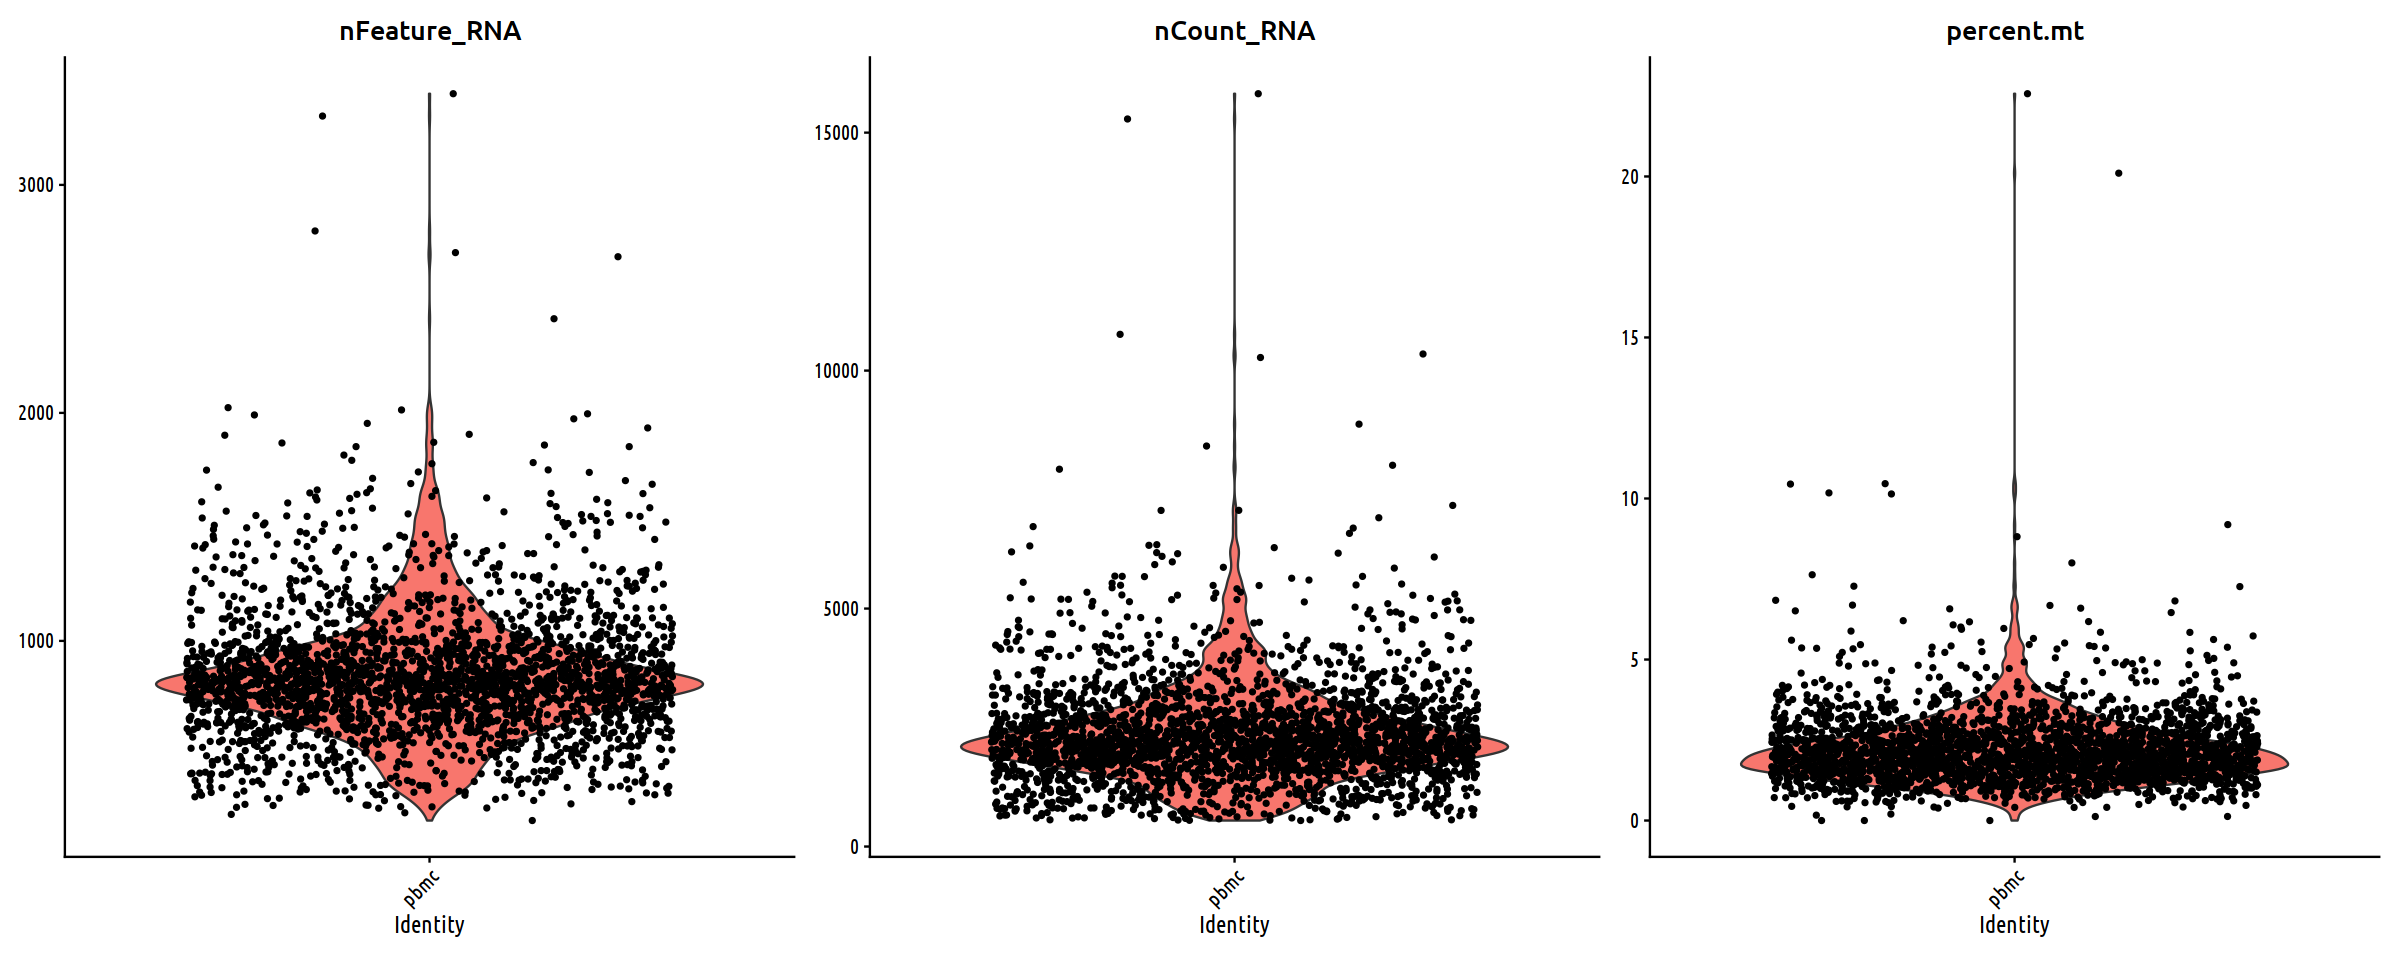

In [6]:
# Visualize QC metrics as a violin plot
options(repr.plot.width=20, repr.plot.height=8)
VlnPlot(sc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

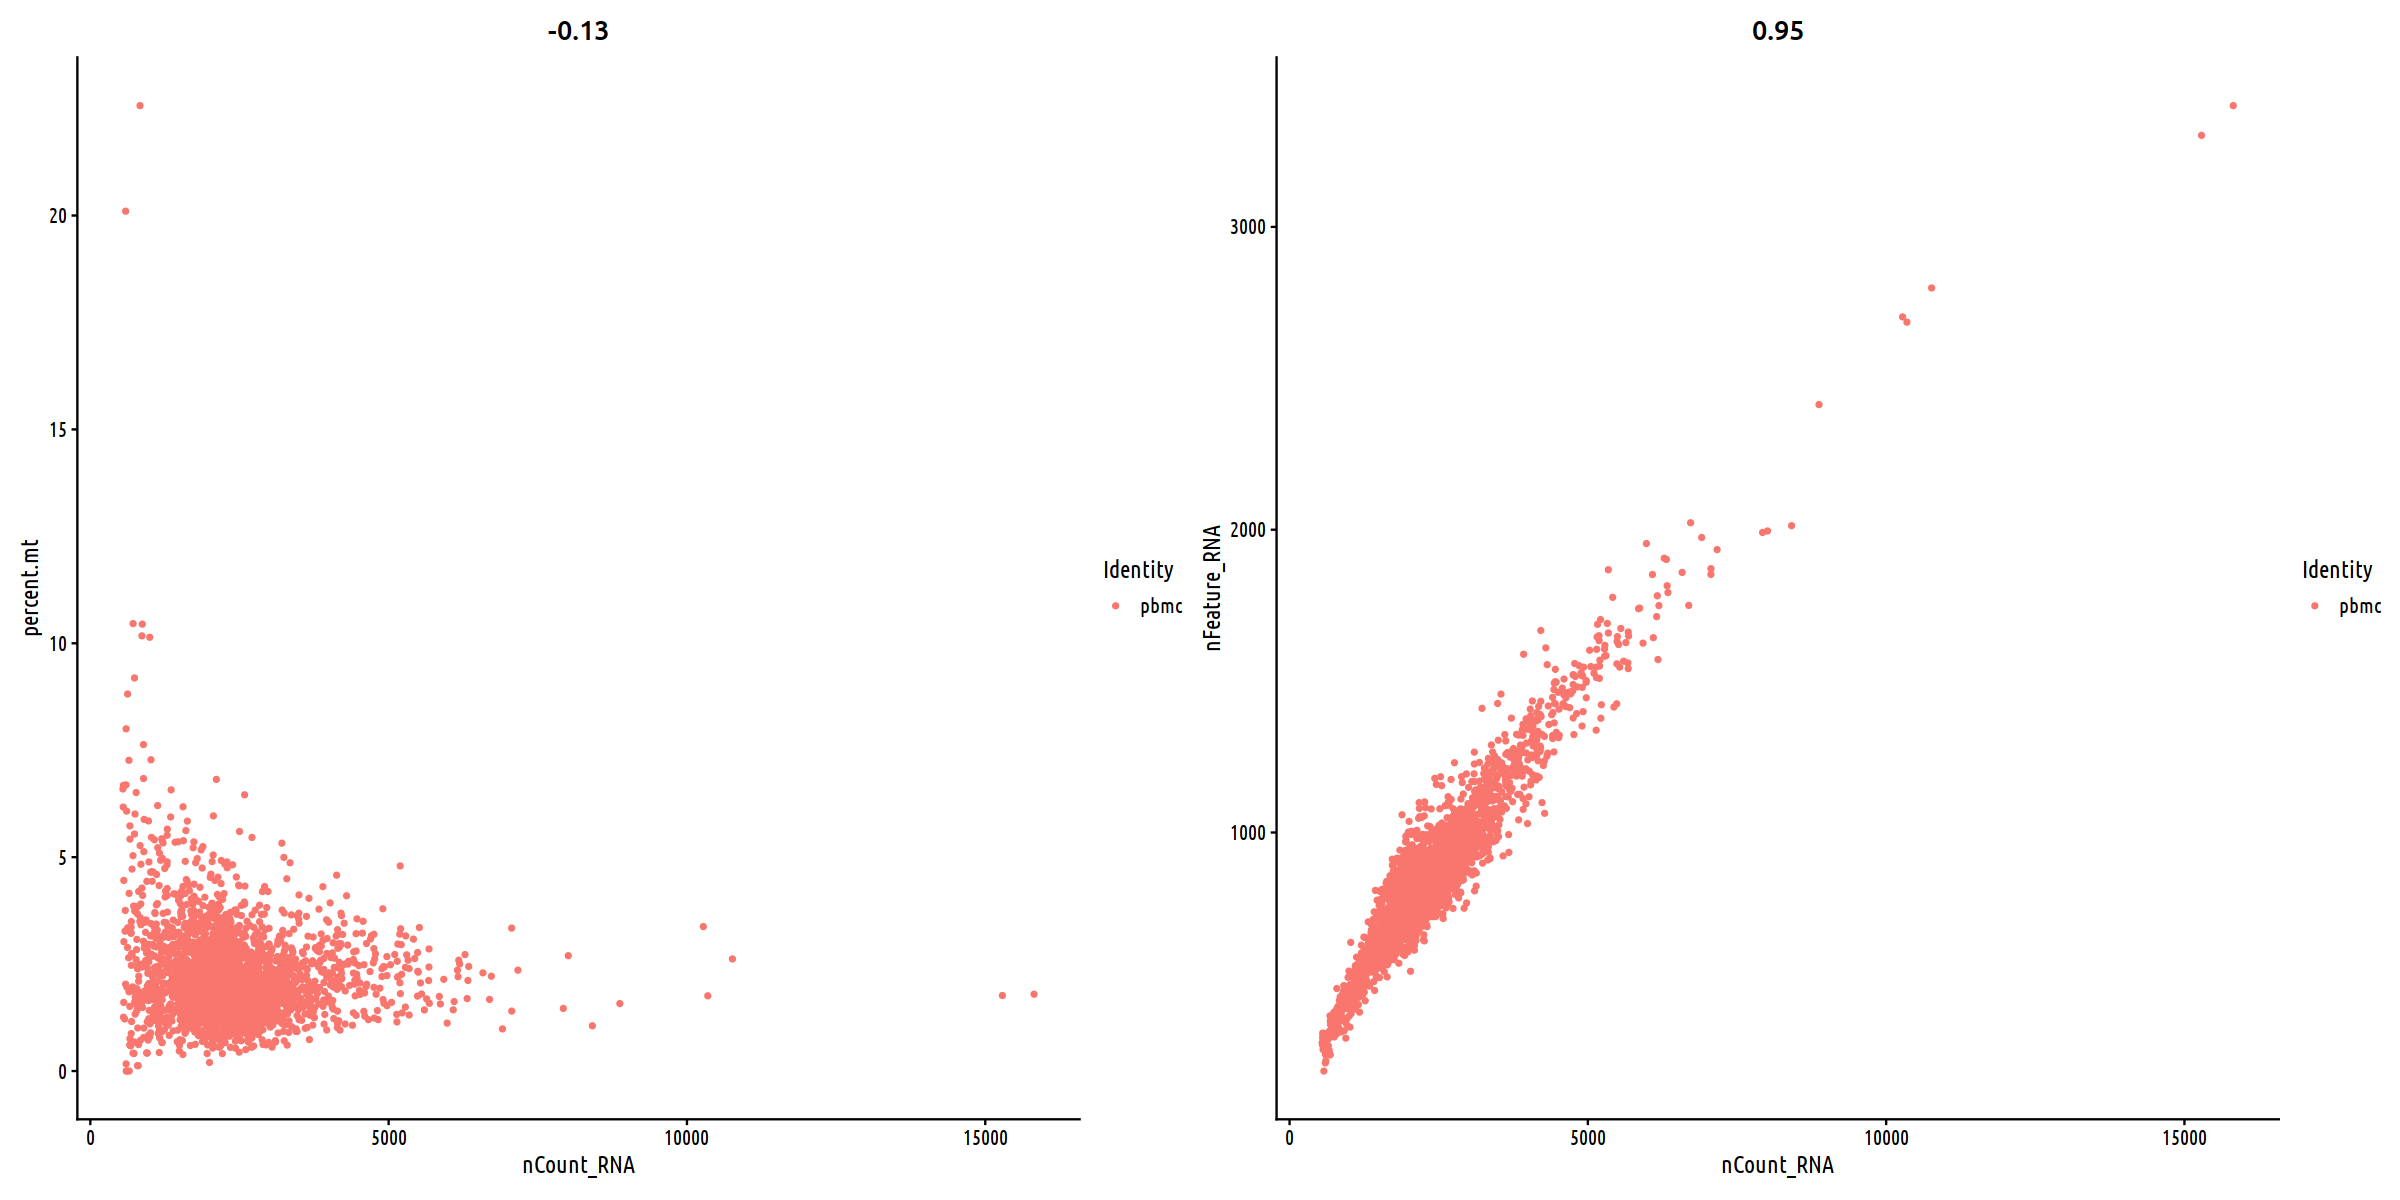

In [7]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
options(repr.plot.width=20, repr.plot.height=10)
plot1 <- FeatureScatter(sc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(sc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [8]:
sc <- subset(sc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Normalizing the data

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method __LogNormalize__ that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. Normalized values are stored in `sc[["RNA"]]@data`.

In [9]:
sc <- NormalizeData(sc, normalization.method = "LogNormalize", scale.factor = 10000)

For clarity, in this previous line of code (and in future commands), we provide the default values for certain parameters in the function call. However, this isn't required and the same behavior can be achieved with:

In [10]:
sc <- NormalizeData(sc)

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Identification of highly variable features or feature selection

We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). Its [reported](https://www.nature.com/articles/nmeth.2645) that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

The method implemented in Seurat3 is described in detail [here](https://www.biorxiv.org/content/early/2018/11/02/460147.full.pdf), and improves on previous versions by directly modeling the mean-variance relationship inherent in single-cell data, and is implemented in the FindVariableFeatures function. By default, we return 2,000 features per dataset. These will be used in downstream analysis, like PCA.

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


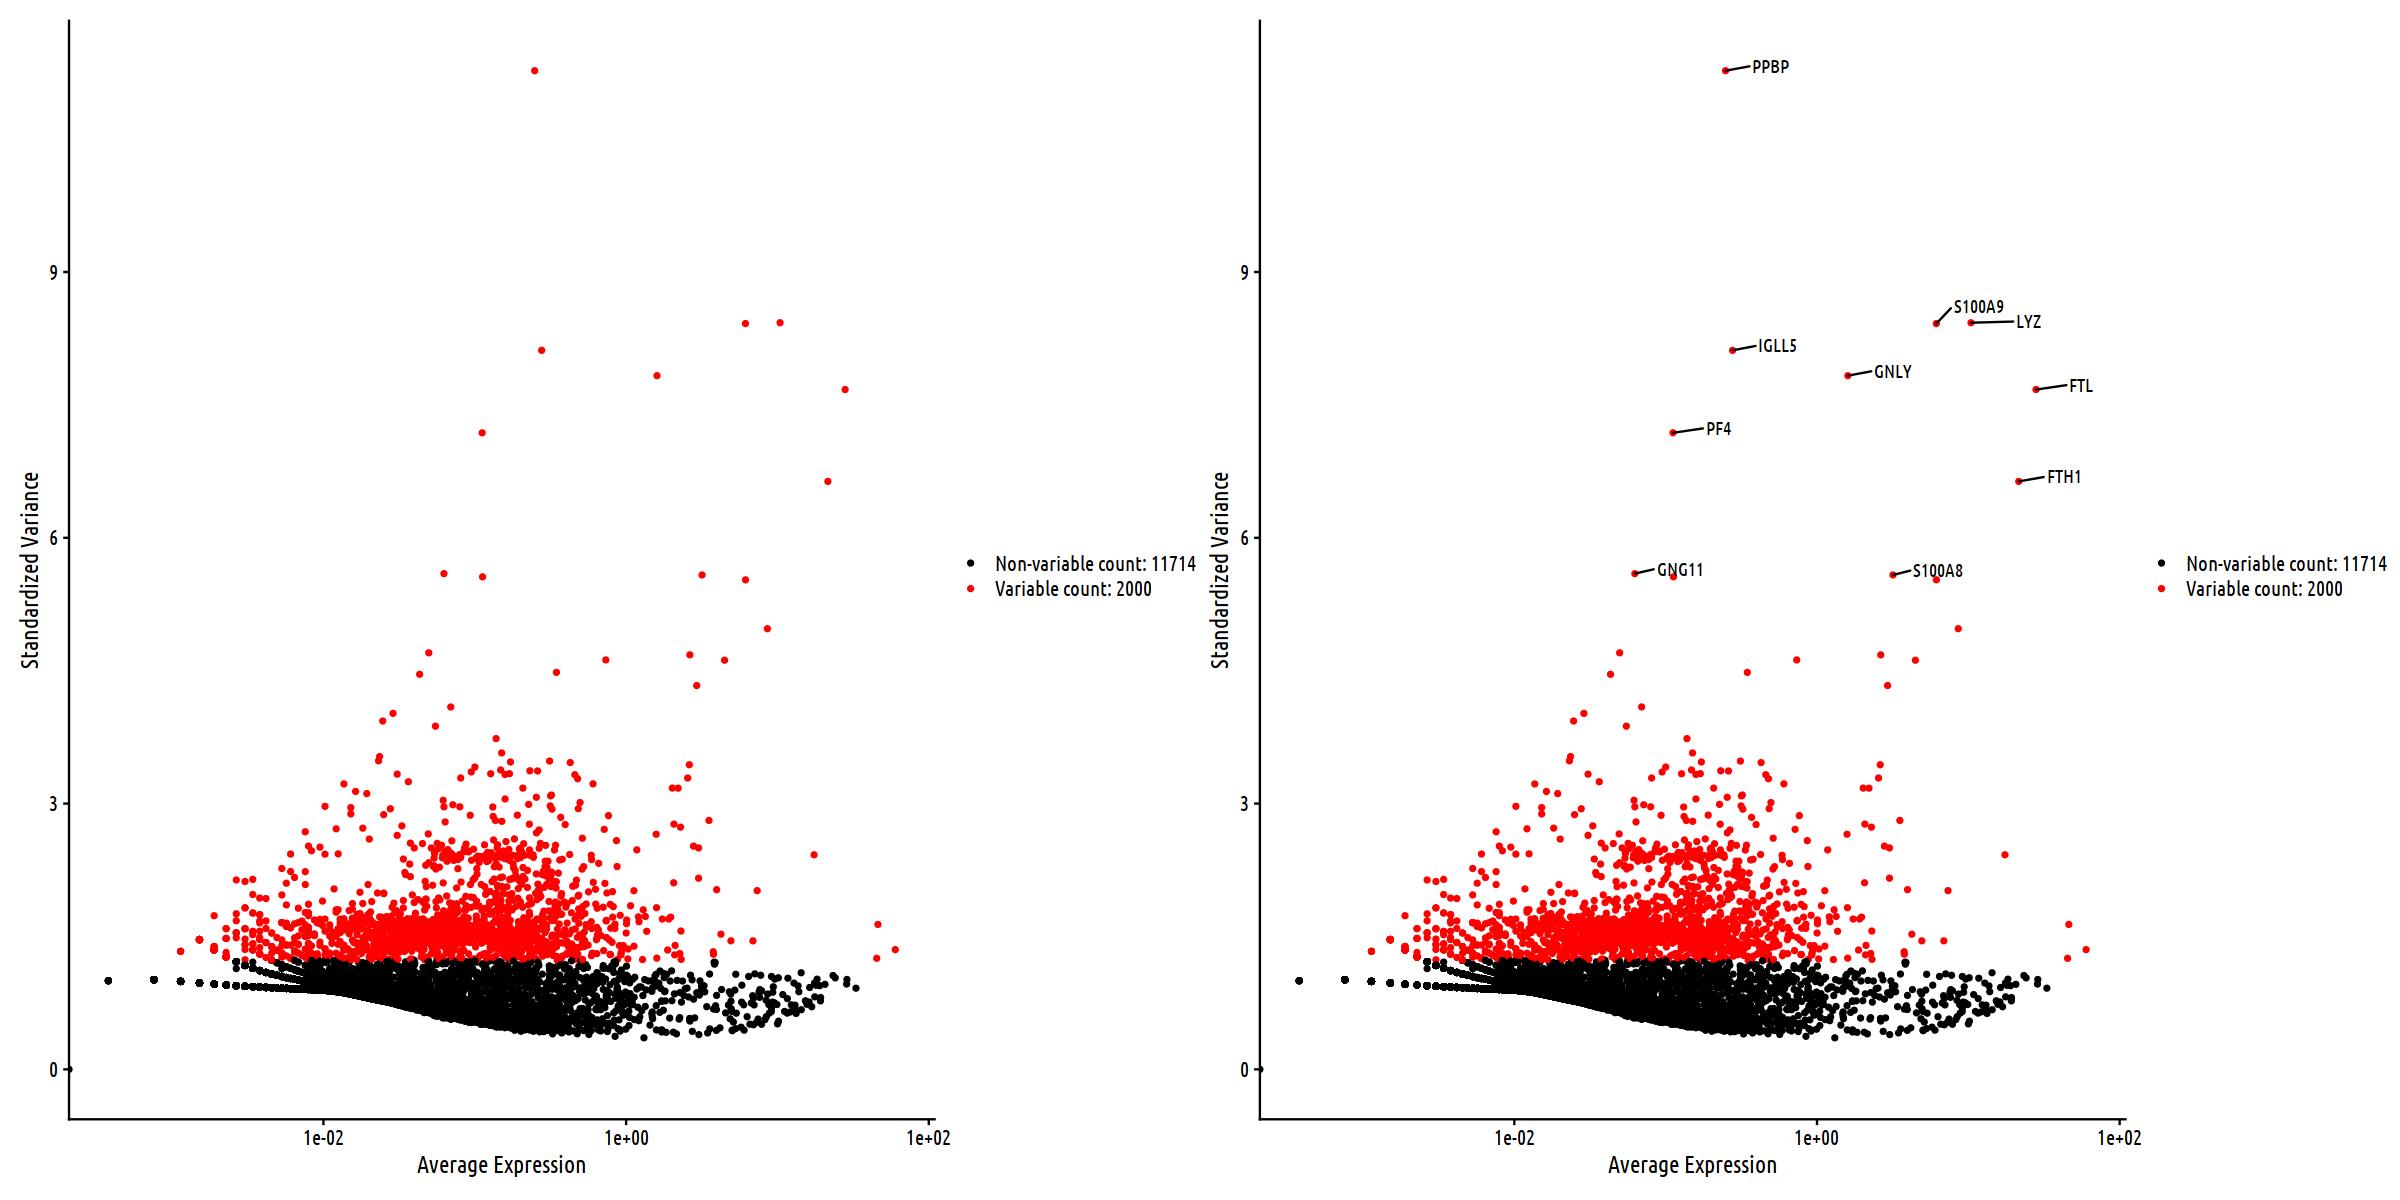

In [11]:
sc <- FindVariableFeatures(sc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(sc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(sc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Scaling the data

Next, we apply a linear transformation ('scaling') that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The `ScaleData` function:

* Shifts the expression of each gene, so that the mean expression across cells is 0
* Scales the expression of each gene, so that the variance across cells is 1
  * This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
* The results of this are stored in `pbmc[["RNA"]]@scale.data`

`ScaleData` function can be used for removing unwanted sources of variation from a single-cell dataset. For example, we could 'regress out' heterogeneity associated with (for example) cell cycle stage, or mitochondrial contamination.

In [12]:
all.genes <- rownames(sc)
sc <- ScaleData(sc, features = all.genes)

Centering and scaling data matrix



<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Perform linear dimensional reduction

Next we perform PCA on the scaled data using the previously determined variable features as input.

In [13]:
sc <- RunPCA(sc, features = VariableFeatures(object = sc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

In [14]:
# Examine and visualize PCA results a few different ways
print(sc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


Visualizing both cells and features that define the PCA using `VizDimReduction`

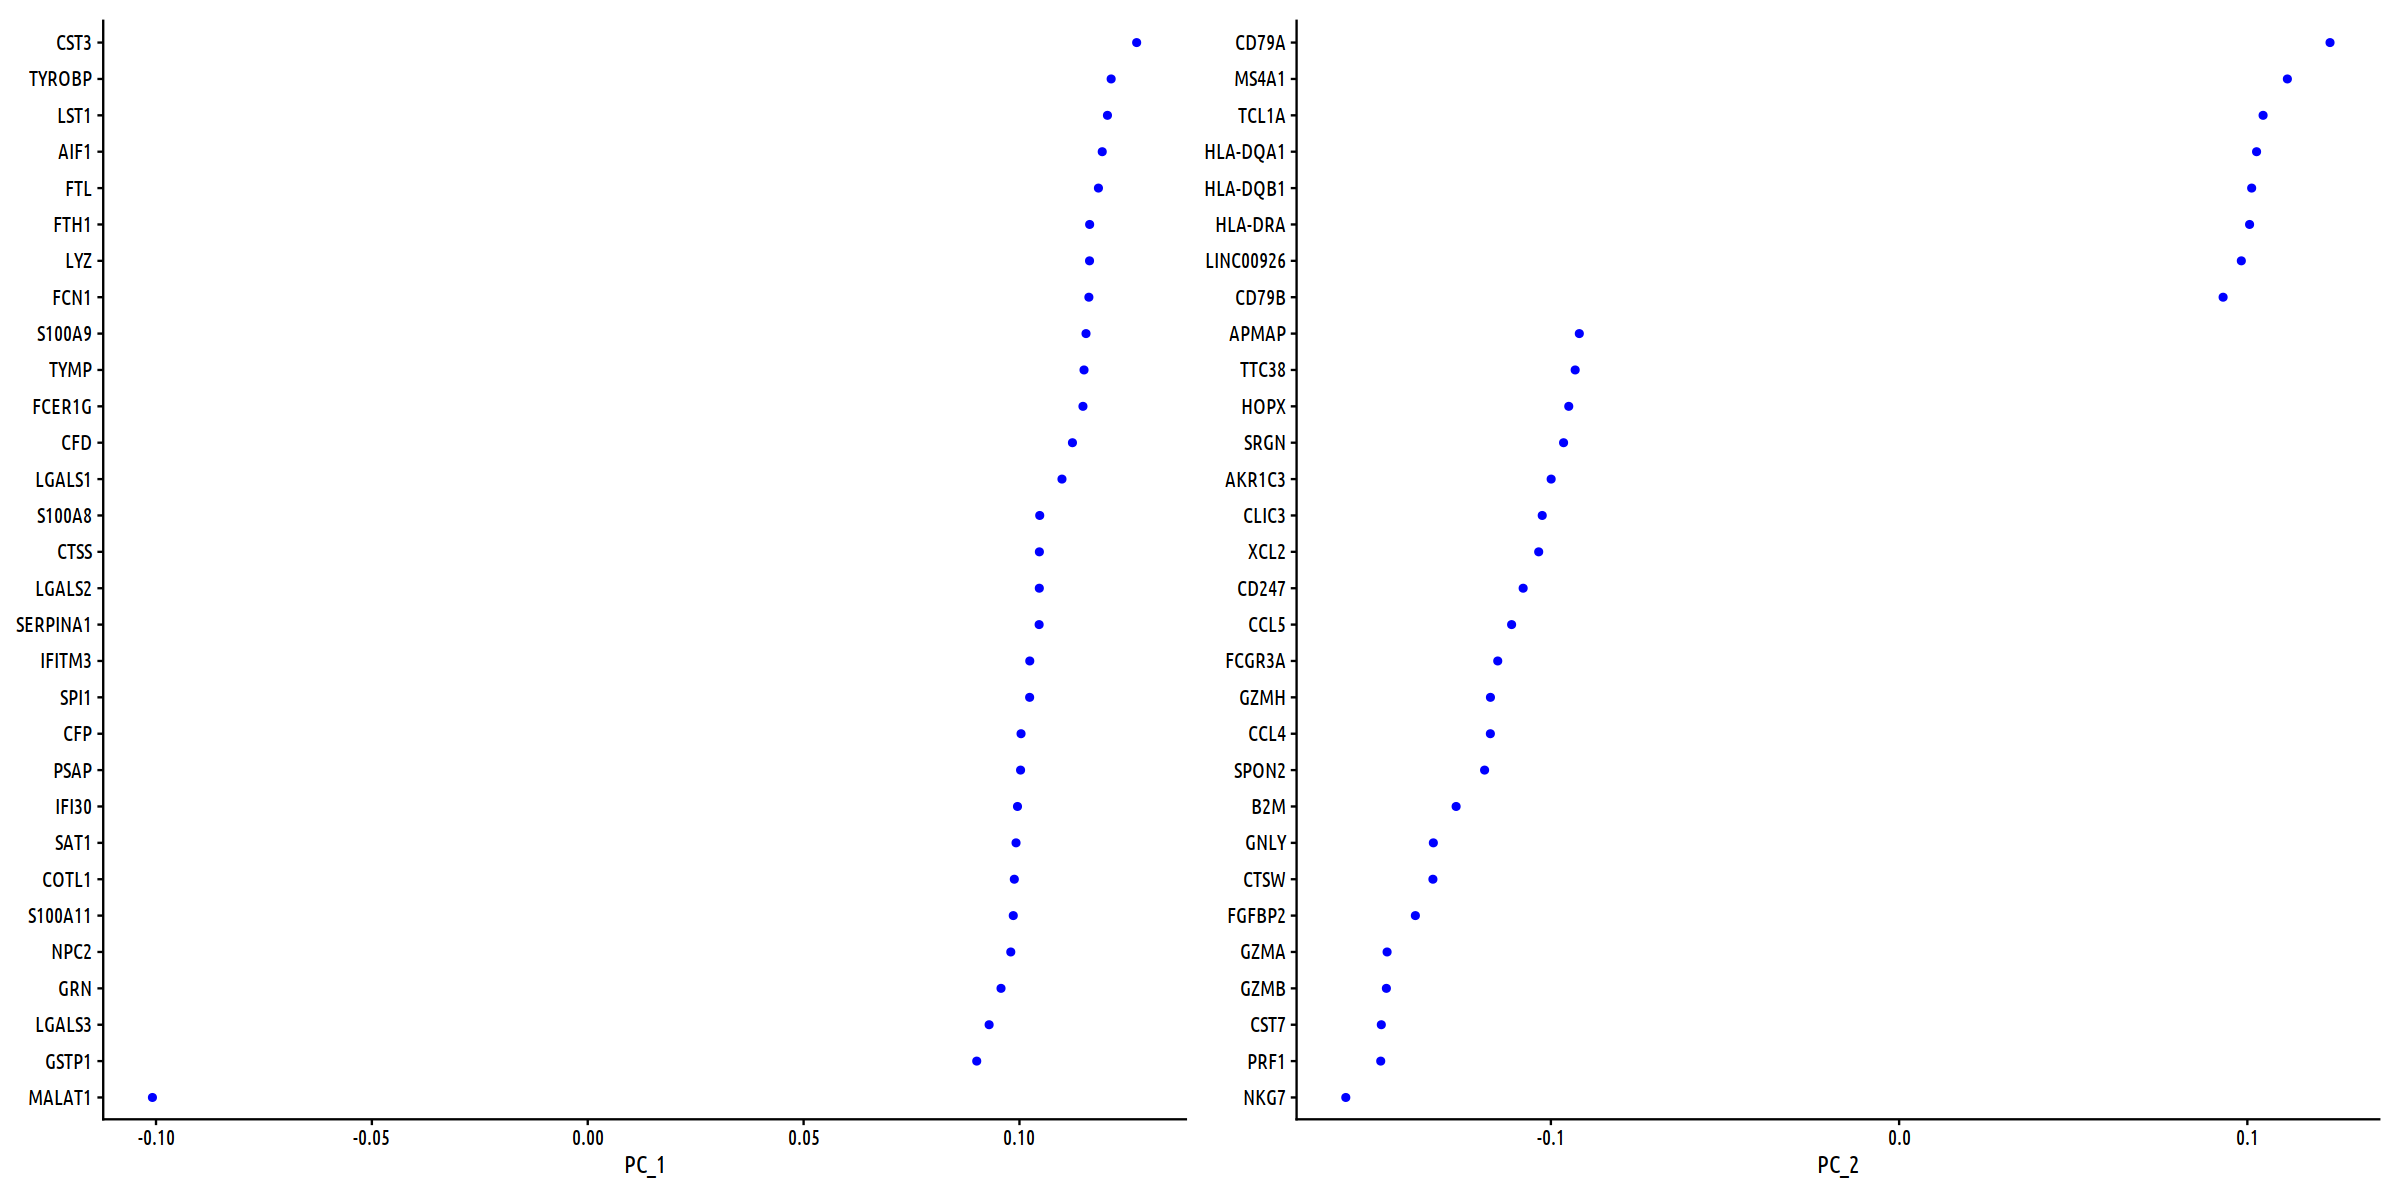

In [15]:
options(repr.plot.width=20, repr.plot.height=10)
VizDimLoadings(sc, dims = 1:2, reduction = "pca")

Visualizing both cells and features that define the PCA using `DimPlot`

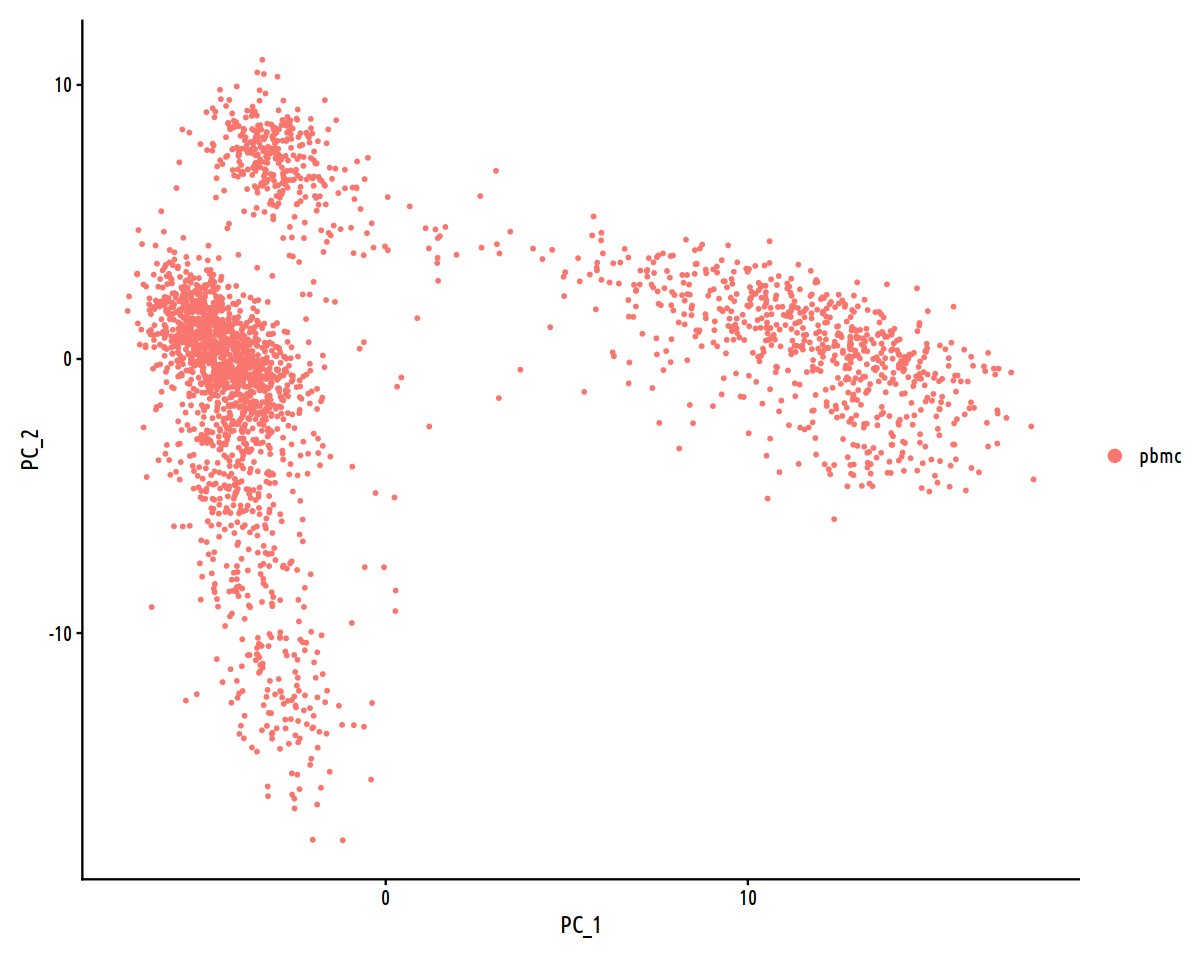

In [16]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sc, reduction = "pca")

In particular `DimHeatmap` allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and features are ordered according to their PCA scores. Setting `cells` to a number plots the 'extreme' cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated feature sets.

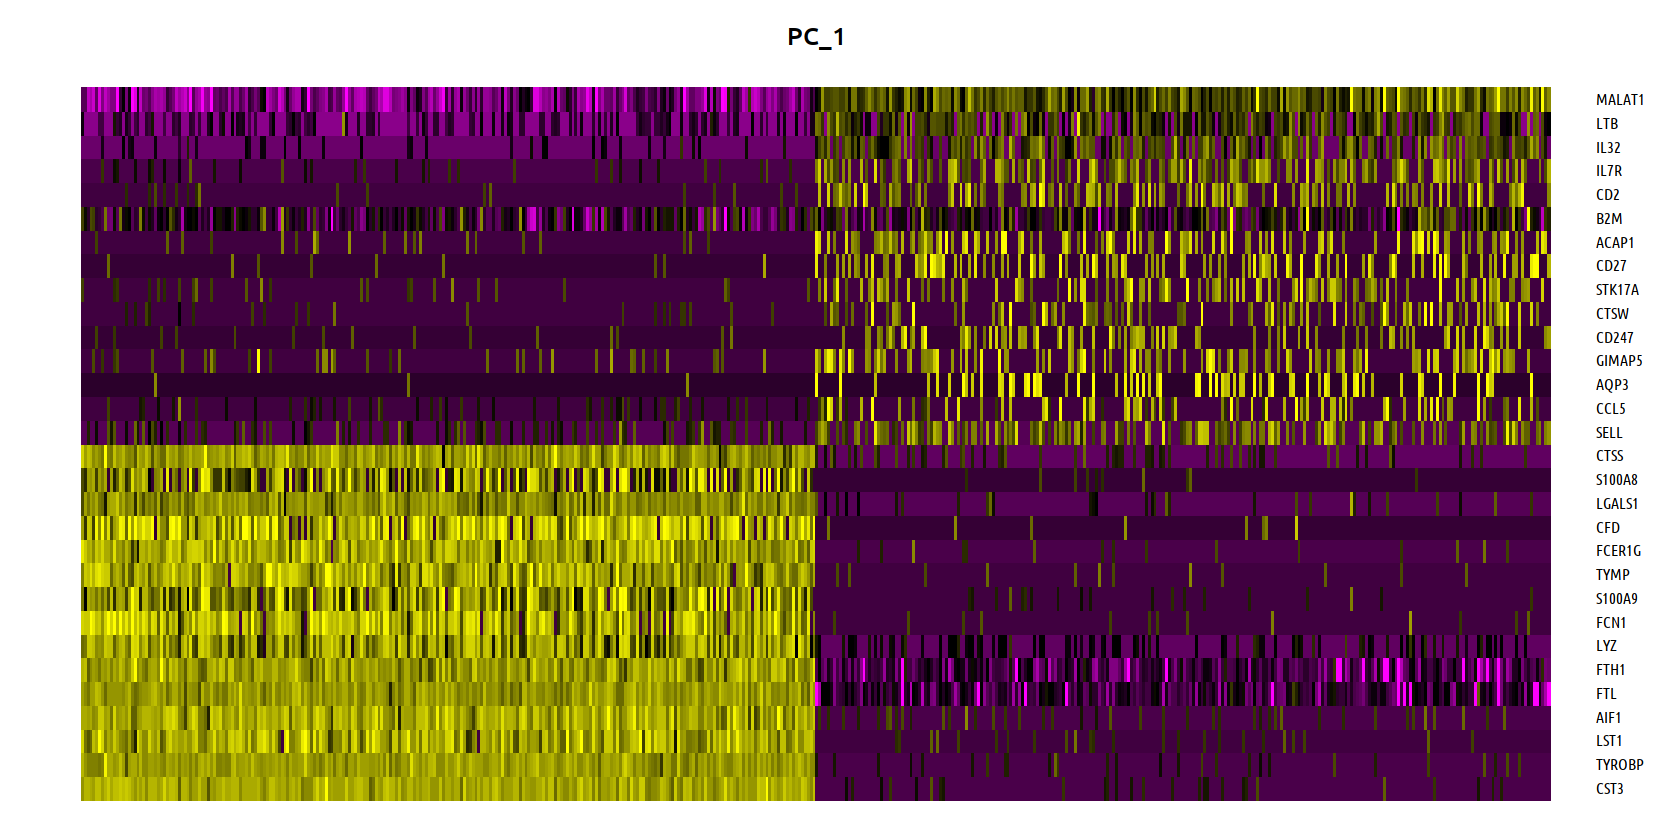

In [17]:
options(repr.plot.width=14, repr.plot.height=7)
DimHeatmap(sc, dims = 1, cells = 500, balanced = TRUE)

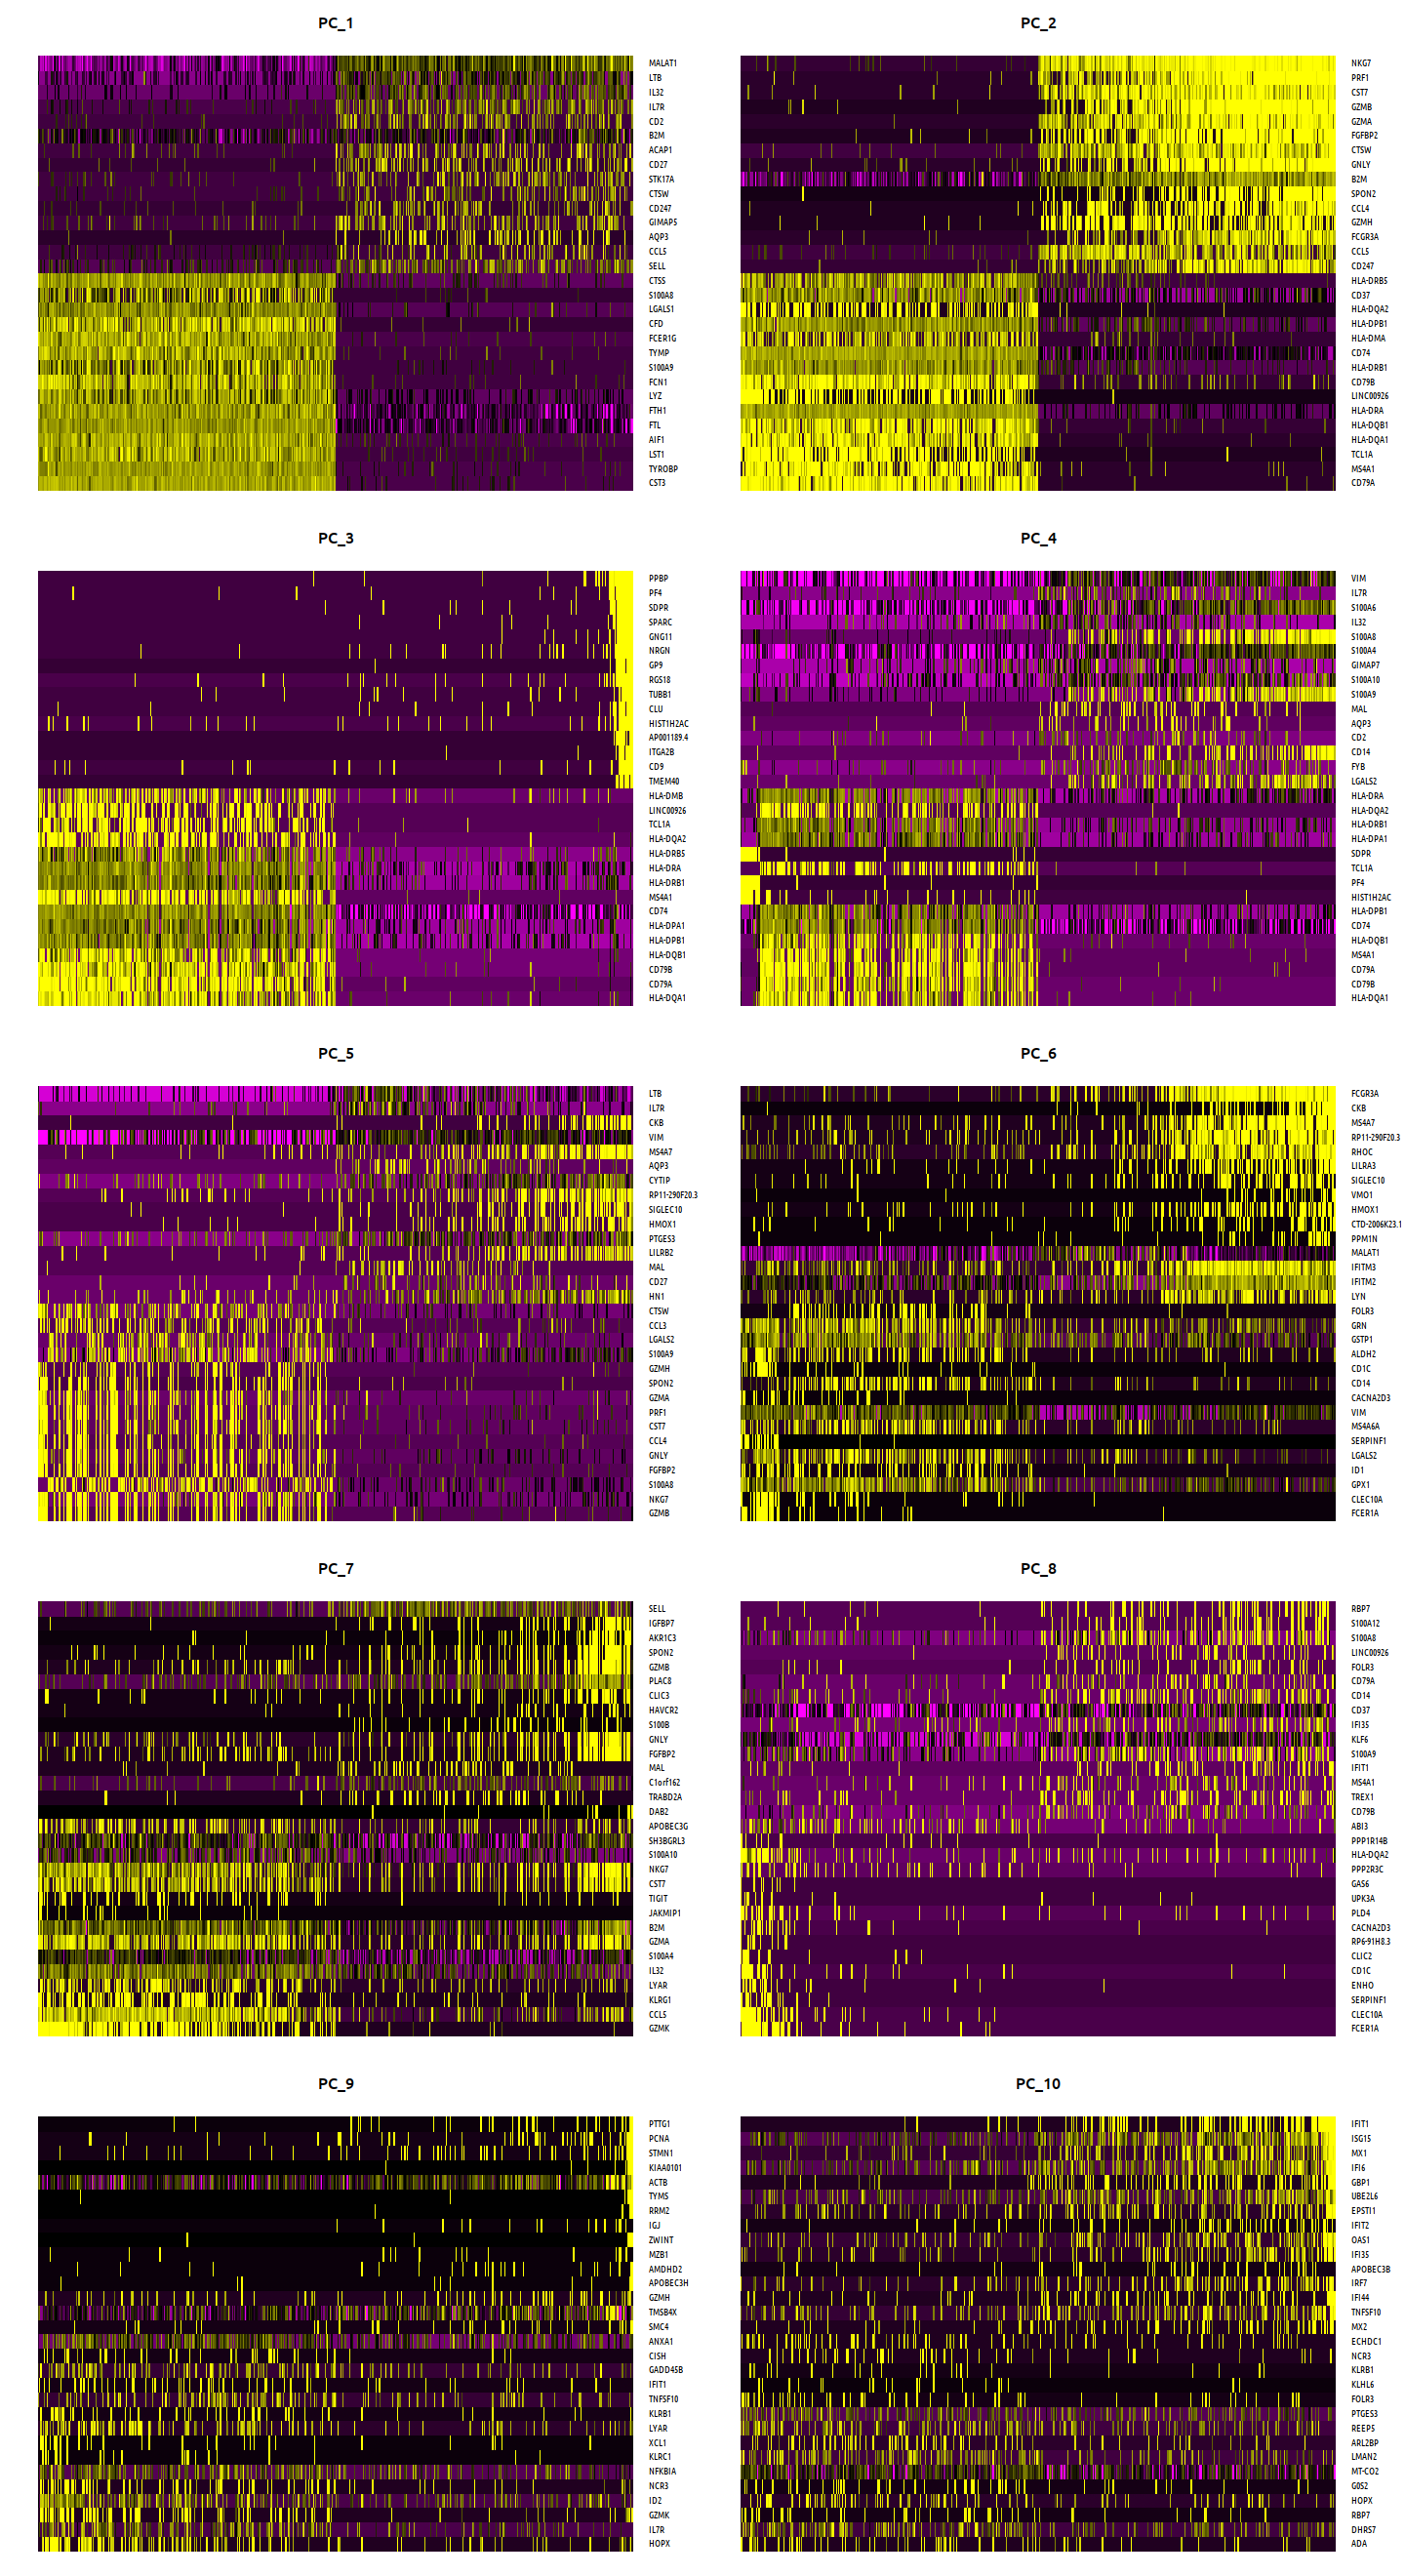

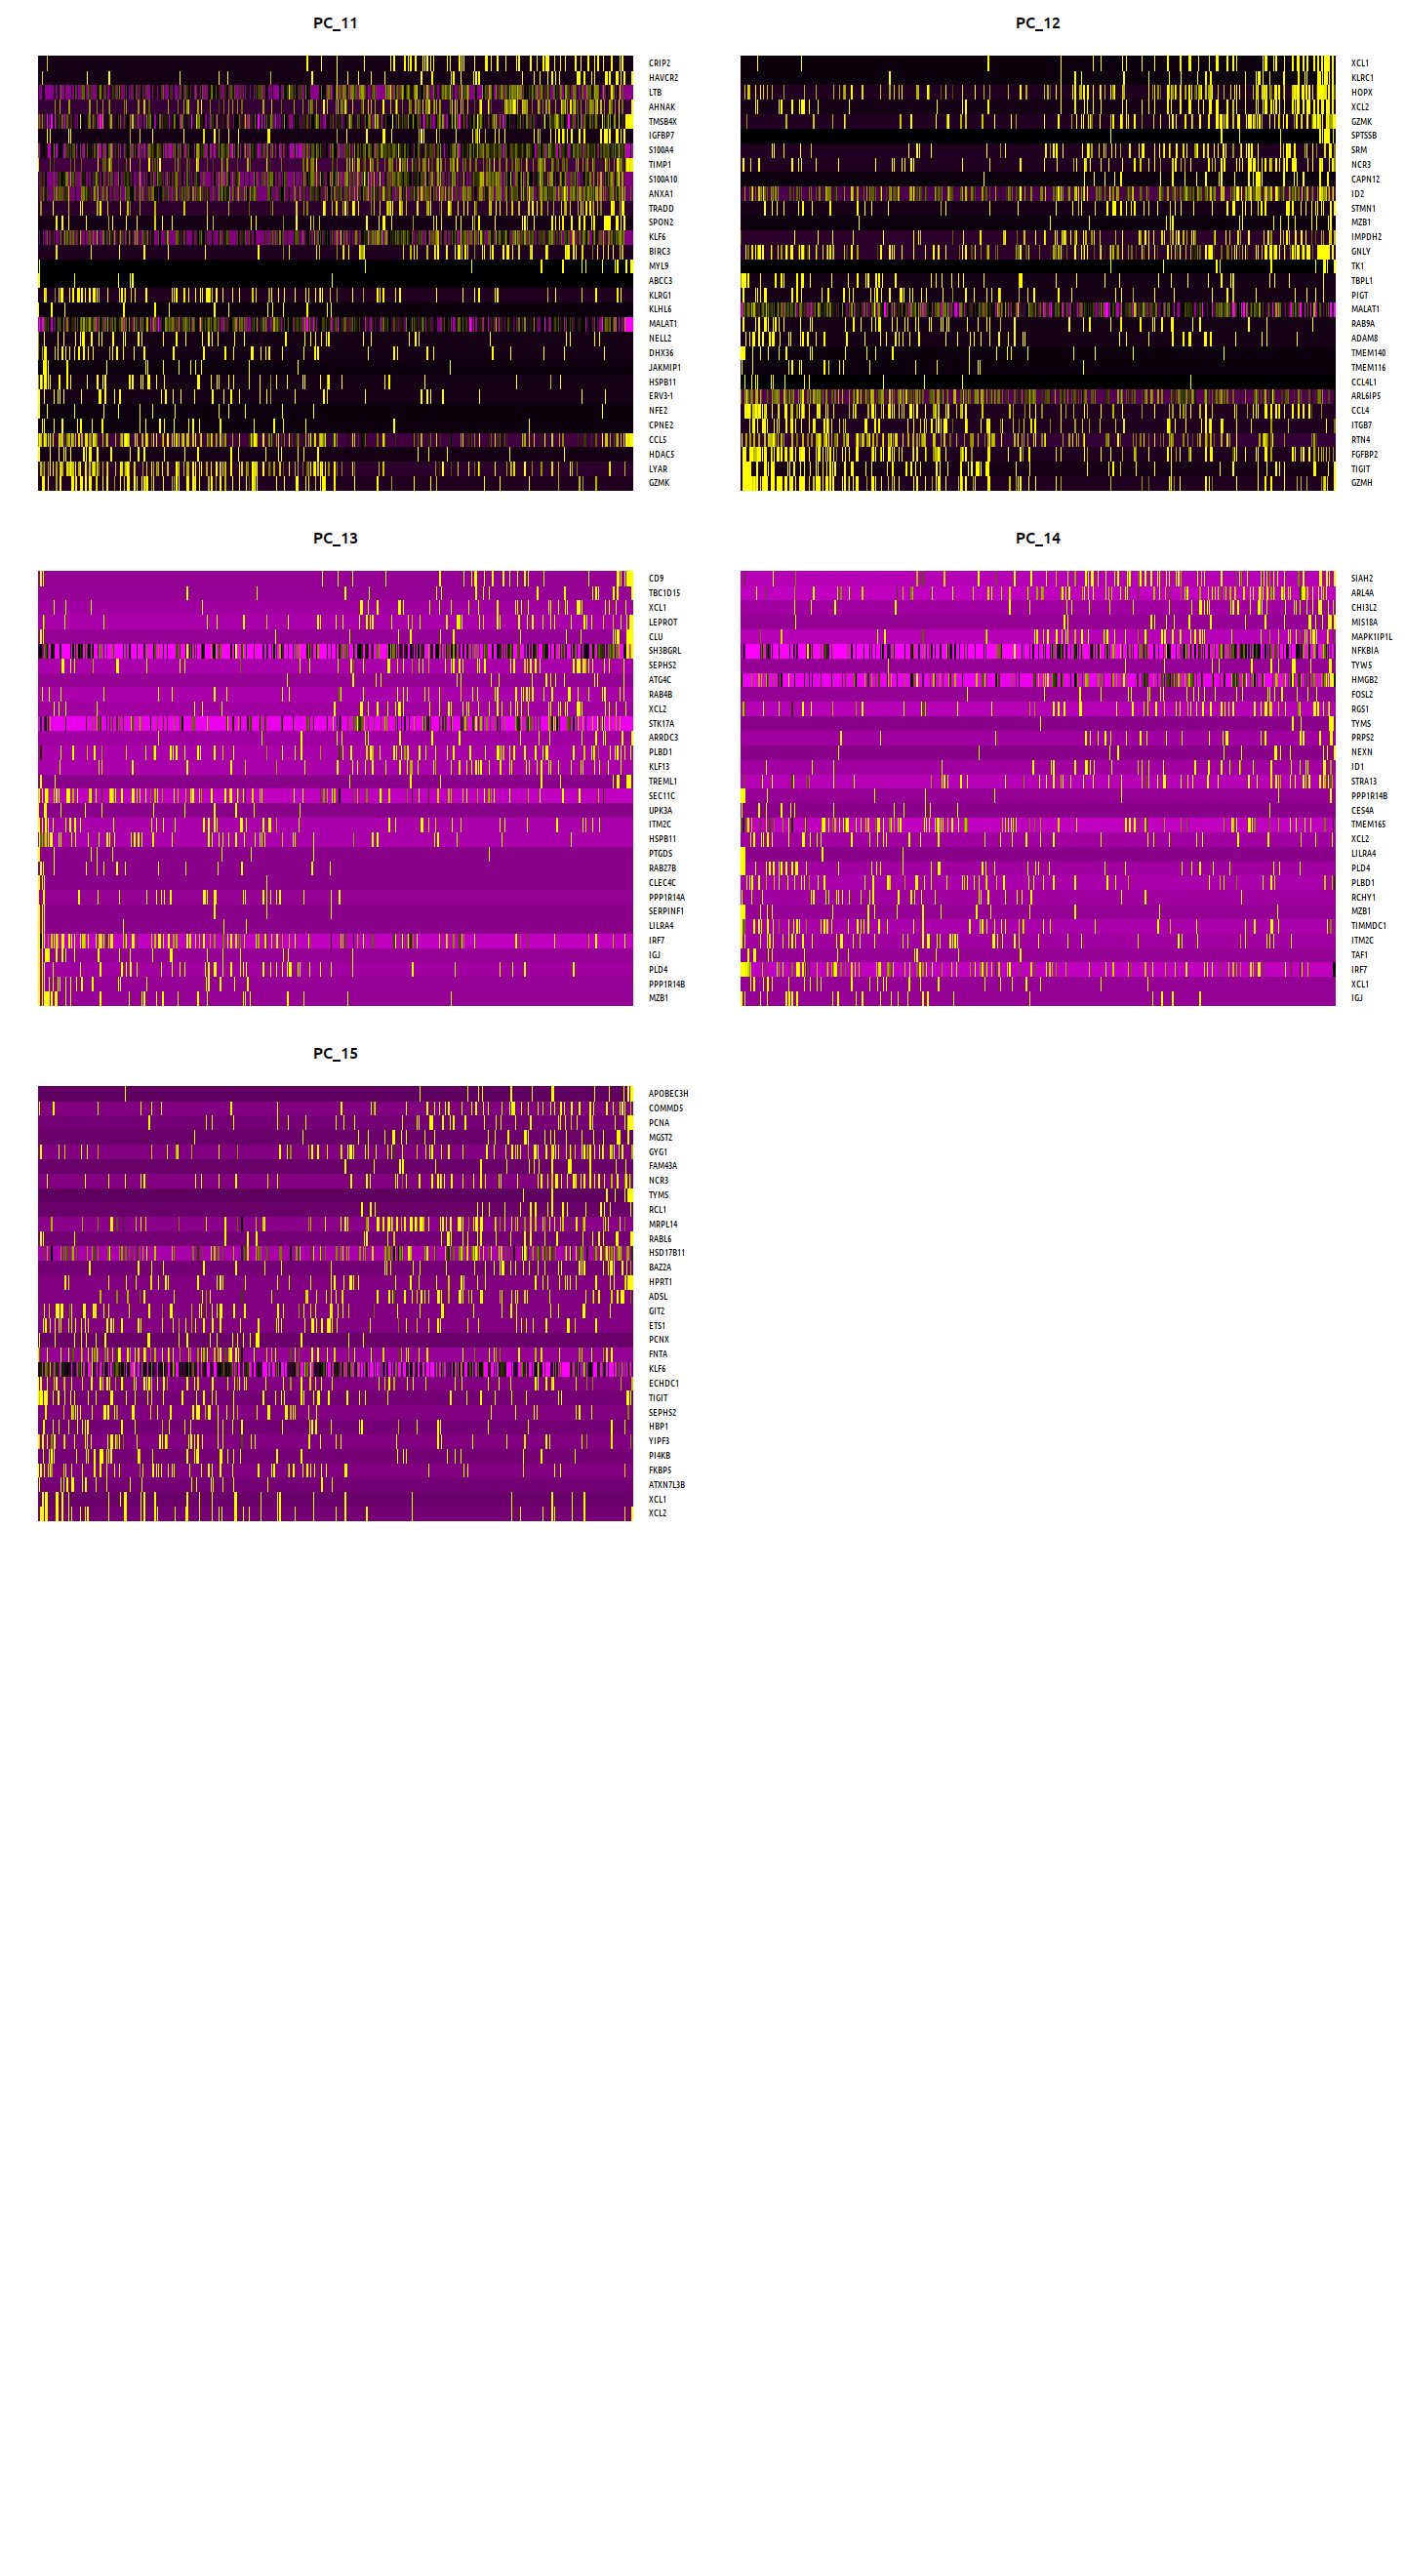

In [18]:
options(repr.plot.width=12, repr.plot.height=22)
DimHeatmap(sc, dims = 1:15, cells = 500, balanced = TRUE,ncol = 2)

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Determine the dimensionality of the dataset

Here, we are generating an 'Elbow plot': a ranking of principle components based on the percentage of variance explained by each one (`ElbowPlot` function). For this analysis, we are using the first 10 PCs.

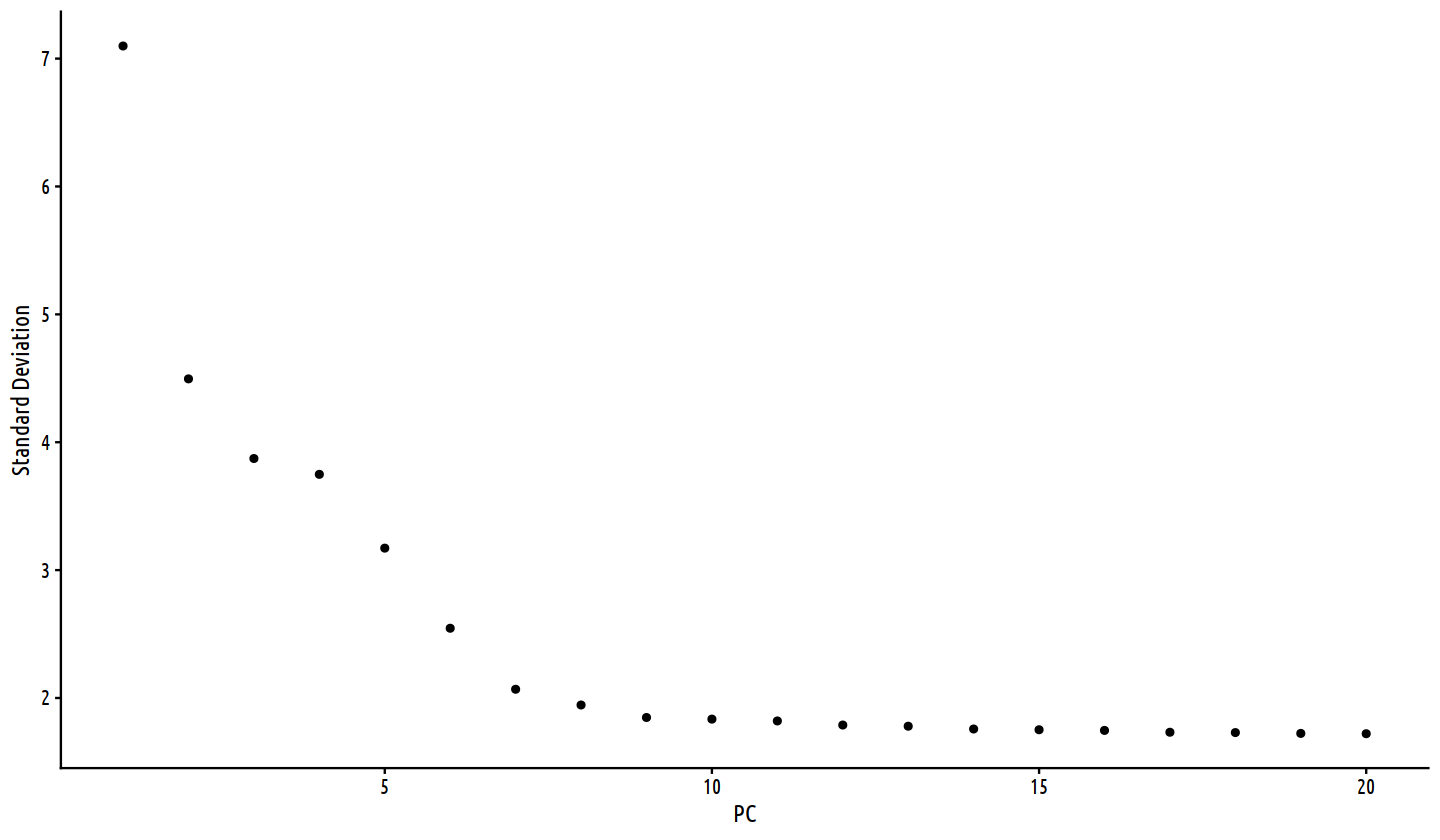

In [19]:
options(repr.plot.width=12, repr.plot.height=7)
ElbowPlot(sc)

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Cluster the cells

Seurat v3 applies a graph-based clustering approach, building upon initial strategies in [Macosko et al](http://www.cell.com/abstract/S0092-8674(15)00549-8). Importantly, the distance metric which drives the clustering analysis (based on previously identified PCs) remains the same. 

Seurat's approach was heavily inspired by recent manuscripts which applied graph-based clustering approaches to scRNA-seq data [SNN-Cliq](http://bioinformatics.oxfordjournals.org/content/early/2015/02/10/bioinformatics.btv088.abstract), [Xu and Su, Bioinformatics, 2015](http://bioinformatics.oxfordjournals.org/content/early/2015/02/10/bioinformatics.btv088.abstract) and CyTOF data [PhenoGraph, Levine et al., Cell, 2015](http://www.ncbi.nlm.nih.gov/pubmed/26095251). Briefly, these methods embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar feature expression patterns, and then attempt to partition this graph into highly interconnected 'quasi-cliques' or 'communities'.

As in PhenoGraph, it first constructs a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). This step is performed using the `FindNeighbors` function, and takes as input the previously defined dimensionality of the dataset (first 10 PCs).

To cluster the cells, Seurat uses modularity optimization techniques such as the Louvain algorithm (default) or SLM [SLM, Blondel et al., Journal of Statistical Mechanics](http://dx.doi.org/10.1088/1742-5468/2008/10/P10008), to iteratively group cells together, with the goal of optimizing the standard modularity function. The `FindClusters` function implements this procedure, and contains a resolution parameter that sets the 'granularity' of the downstream clustering, with increased values leading to a greater number of clusters. Its recommended to set this parameter bewteen 0.4-1.2 for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters can be found using the `Idents` function.

In [20]:
sc <- FindNeighbors(sc, dims = 1:10)
sc <- FindClusters(sc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 96033

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8720
Number of communities: 9
Elapsed time: 0 seconds


In [21]:
# Look at cluster IDs of the first 5 cells
head(Idents(sc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               1                3                1                2 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Run non-linear dimensional reduction UMAP

Seurat offers several non-linear dimensional reduction techniques, such as tSNE and UMAP, to visualize and explore these datasets. The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimensional space. Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots. As input to the UMAP and tSNE, we suggest using the same PCs as input to the clustering analysis.


In [22]:
sc <- RunUMAP(sc, dims = 1:10)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
14:32:48 UMAP embedding parameters a = 0.9922 b = 1.112

14:32:48 Read 2638 rows and found 10 numeric columns

14:32:48 Using Annoy for neighbor search, n_neighbors = 30

14:32:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:32:49 Writing NN index file to temp file /home/vmuser/.tmp/RtmppC1KgP/file29376a4bb8

14:32:49 Searching Annoy index using 1 thread, search_k = 3000

14:32:50 Annoy recall = 100%

14:32:50 Commencing smooth kNN distance calibration using 1 thread

14:32:51 Initi

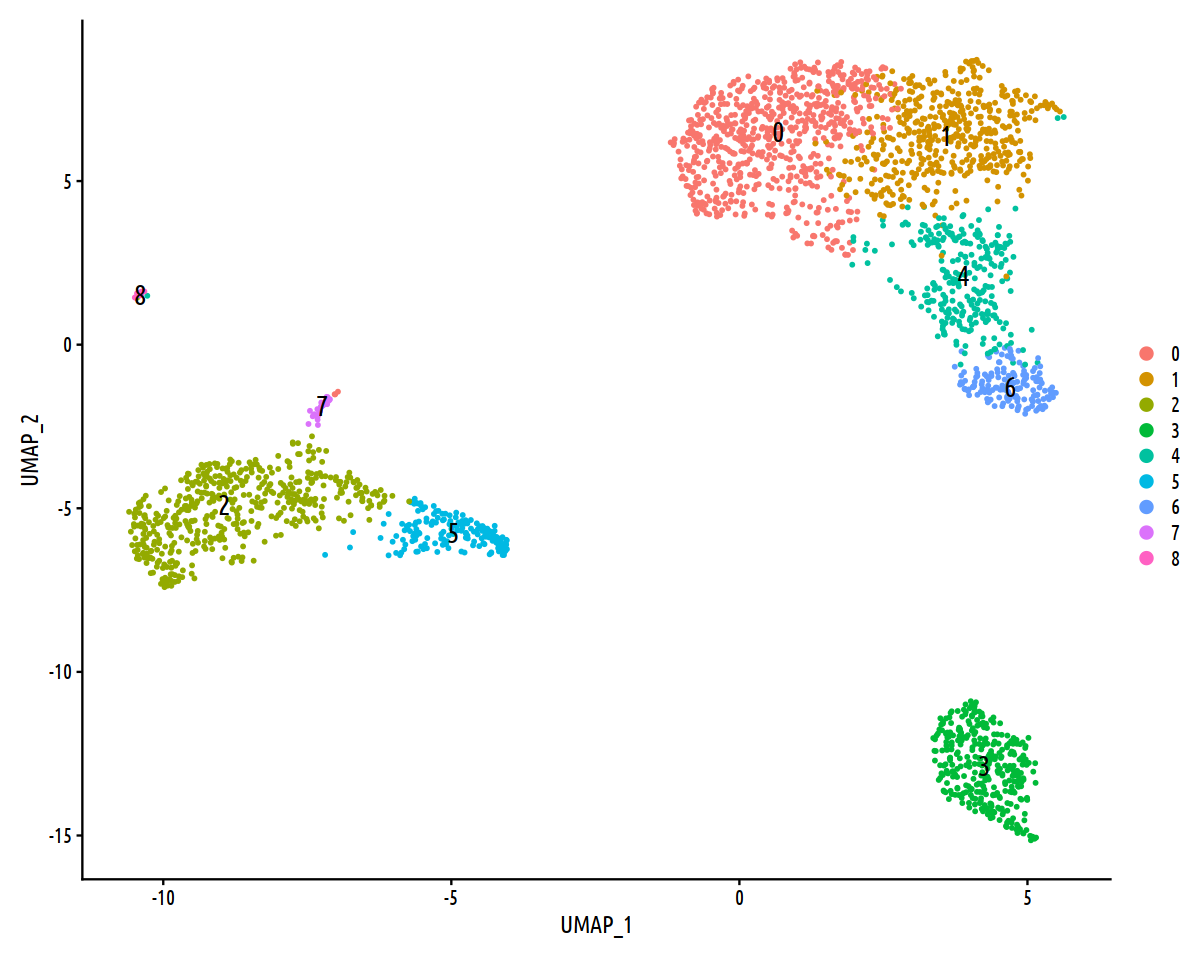

In [23]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(sc, reduction = "umap",label=TRUE,label.size=6)

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## Finding differentially expressed features or cluster biomarkers

Seurat can help you find markers that define clusters via differential expression. By default, it identifes positive and negative markers of a single cluster (specified in `ident.1`), compared to all other cells. `FindAllMarkers` automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The `min.pct` argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. As another option to speed up these computations, `max.cells.per.ident` can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significiant and the most highly differentially expressed features will likely still rise to the top.

In [24]:
# find all markers of cluster 1
cluster1.markers <- FindMarkers(sc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,1.894810e-92,0.8373872,0.948,0.464,2.598542e-88
LTB,7.953303e-89,0.8921170,0.981,0.642,1.090716e-84
CD3D,1.655937e-70,0.6436286,0.919,0.431,2.270951e-66
IL7R,3.688893e-68,0.8147082,0.747,0.325,5.058947e-64
LDHB,2.292819e-67,0.6253110,0.950,0.613,3.144372e-63


In [25]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
sc.markers <- FindAllMarkers(sc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
sc.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.963031e-107,0.7300635,0.901,0.594,2.692101e-103,0,LDHB
1.606796e-82,0.9219135,0.436,0.110,2.203560e-78,0,CCR7
3.191555e-50,0.6926087,0.628,0.358,4.376899e-46,0,NOSIP
3.324866e-49,0.7296372,0.336,0.104,4.559722e-45,0,LEF1
2.498572e-44,0.7119736,0.331,0.110,3.426542e-40,0,PRKCQ-AS1
1.894810e-92,0.8373872,0.948,0.464,2.598542e-88,1,IL32
7.953303e-89,0.8921170,0.981,0.642,1.090716e-84,1,LTB
3.688893e-68,0.8147082,0.747,0.325,5.058947e-64,1,IL7R
2.504468e-61,0.8559204,0.652,0.244,3.434627e-57,1,CD2


Seurat also includes several tools for visualizing marker expression. `DoHeatmap` generates an expression heatmap for given cells and features. In this case, we are plotting the top 10 markers (or all markers if less than 10) for each cluster.

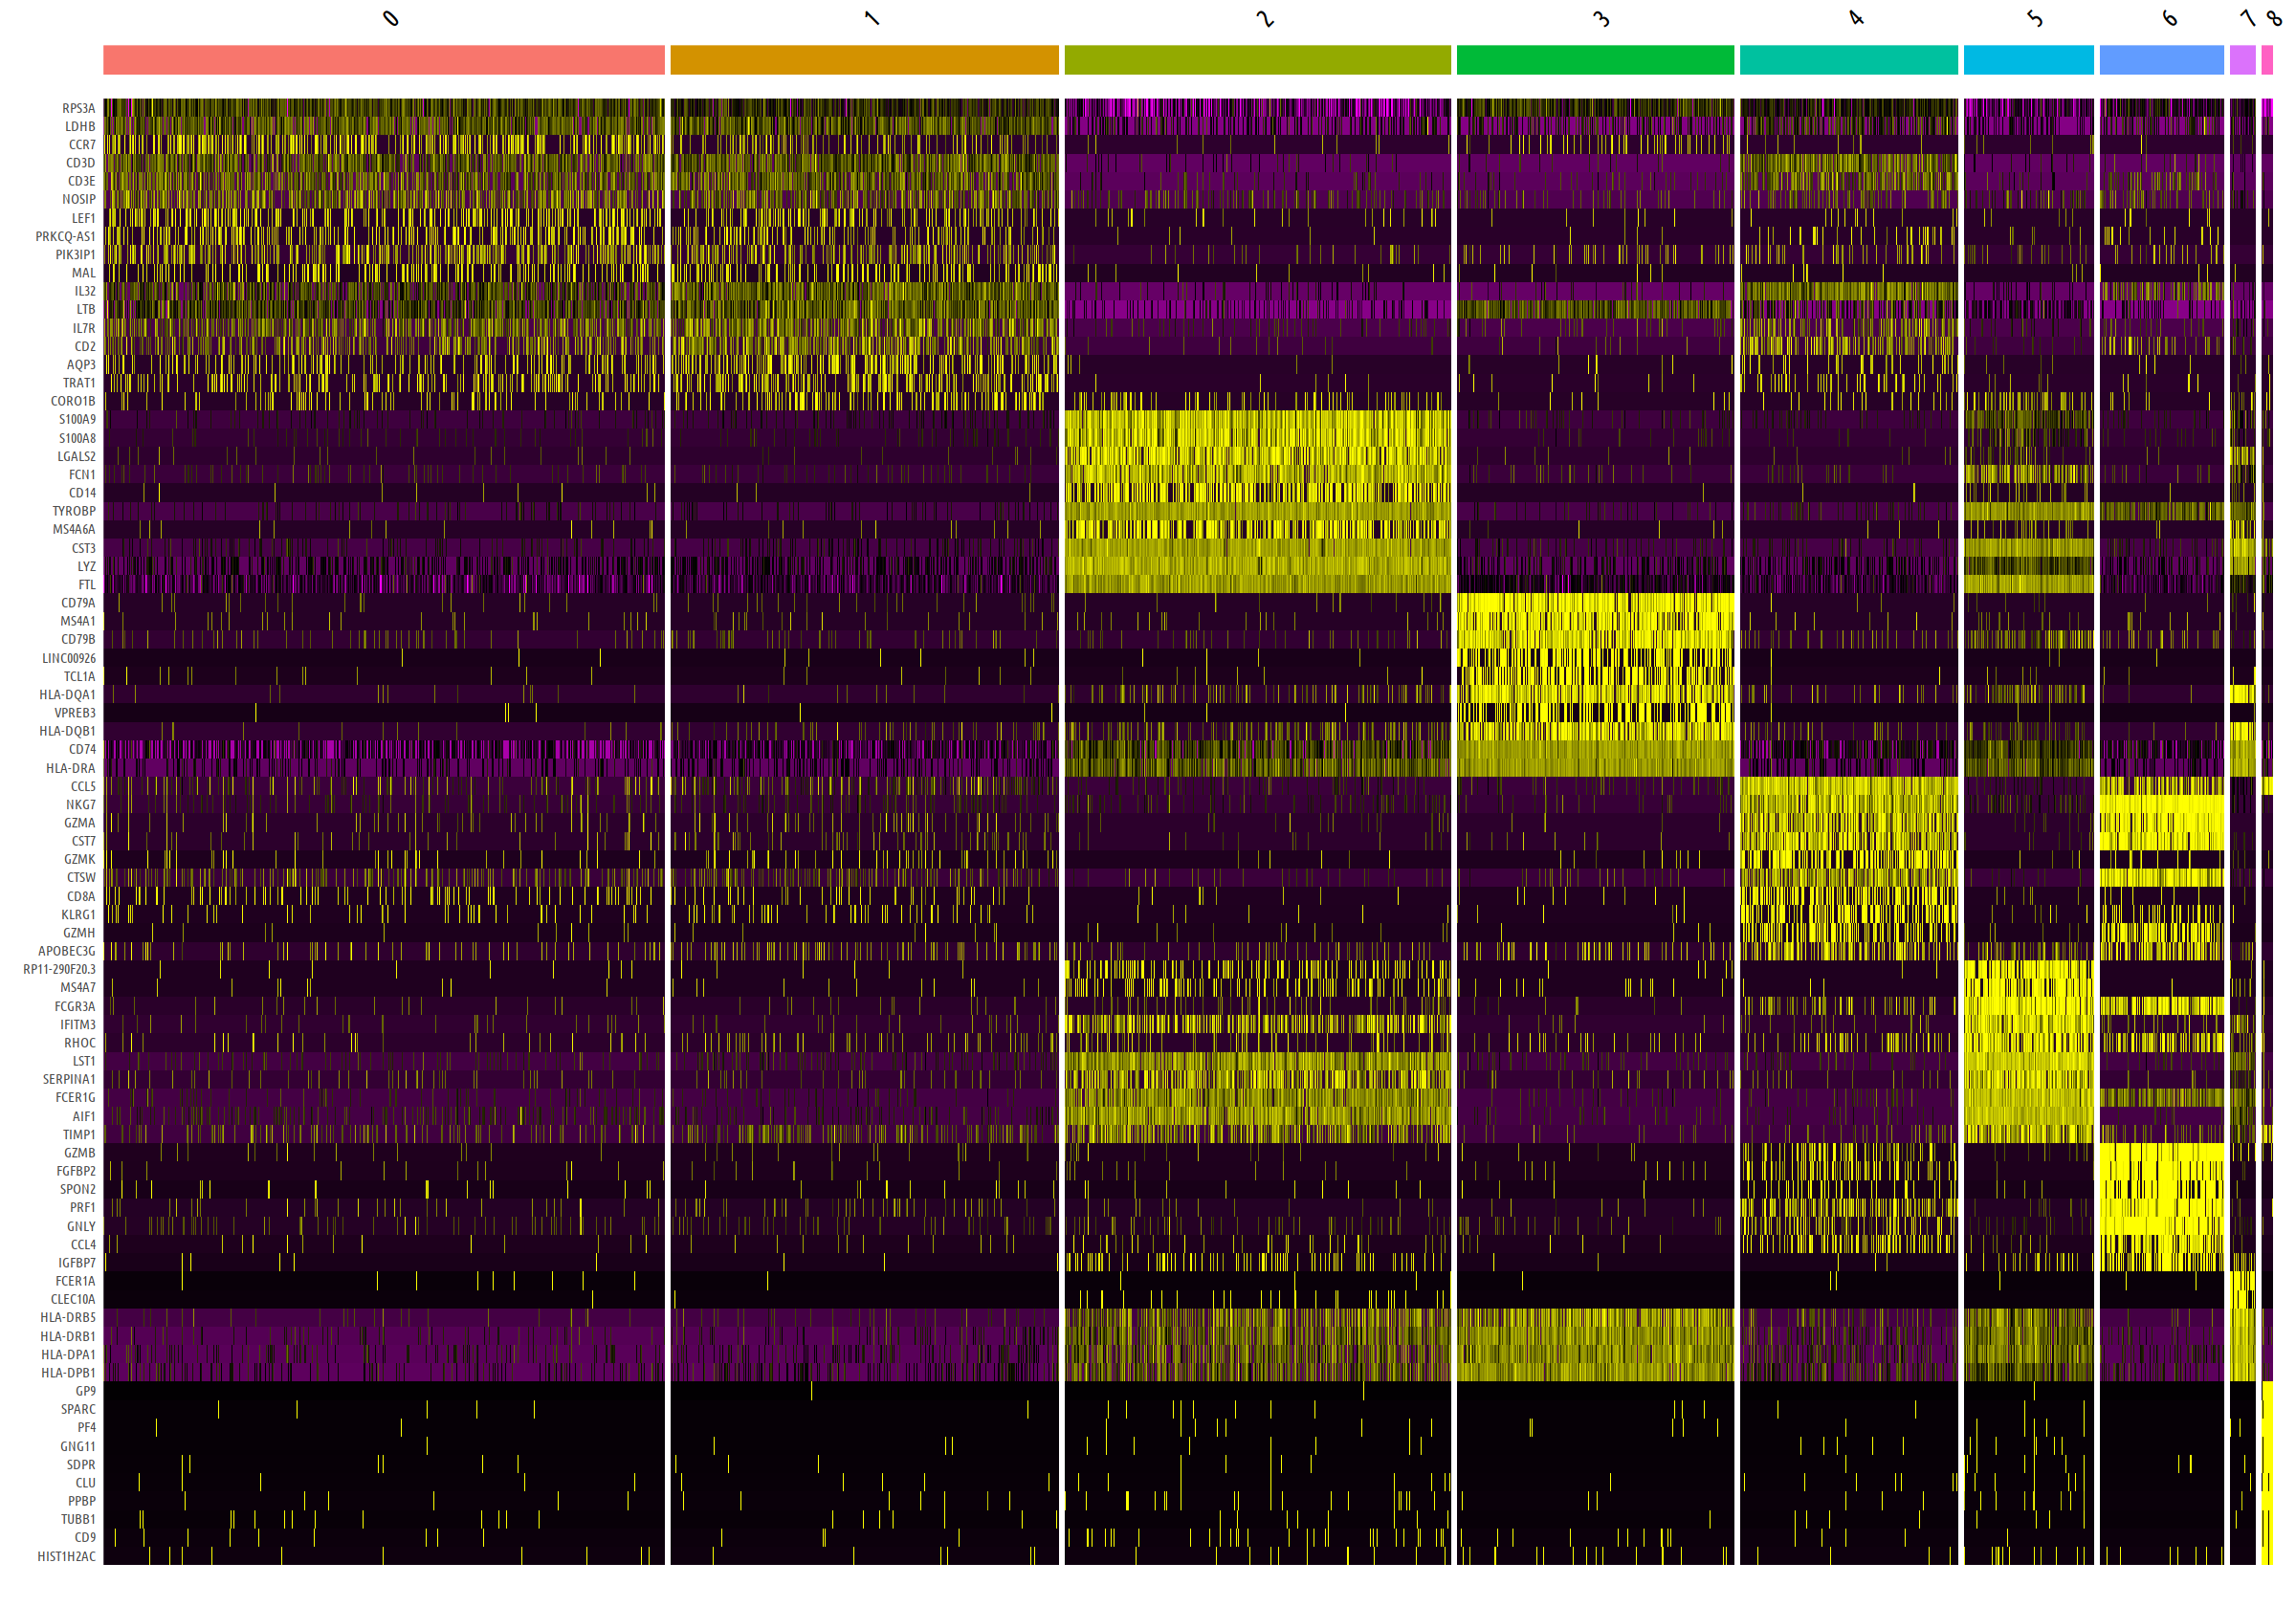

In [26]:
options(repr.plot.width=20, repr.plot.height=14)
top10 <- sc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(sc, features = top10$gene) + NoLegend()

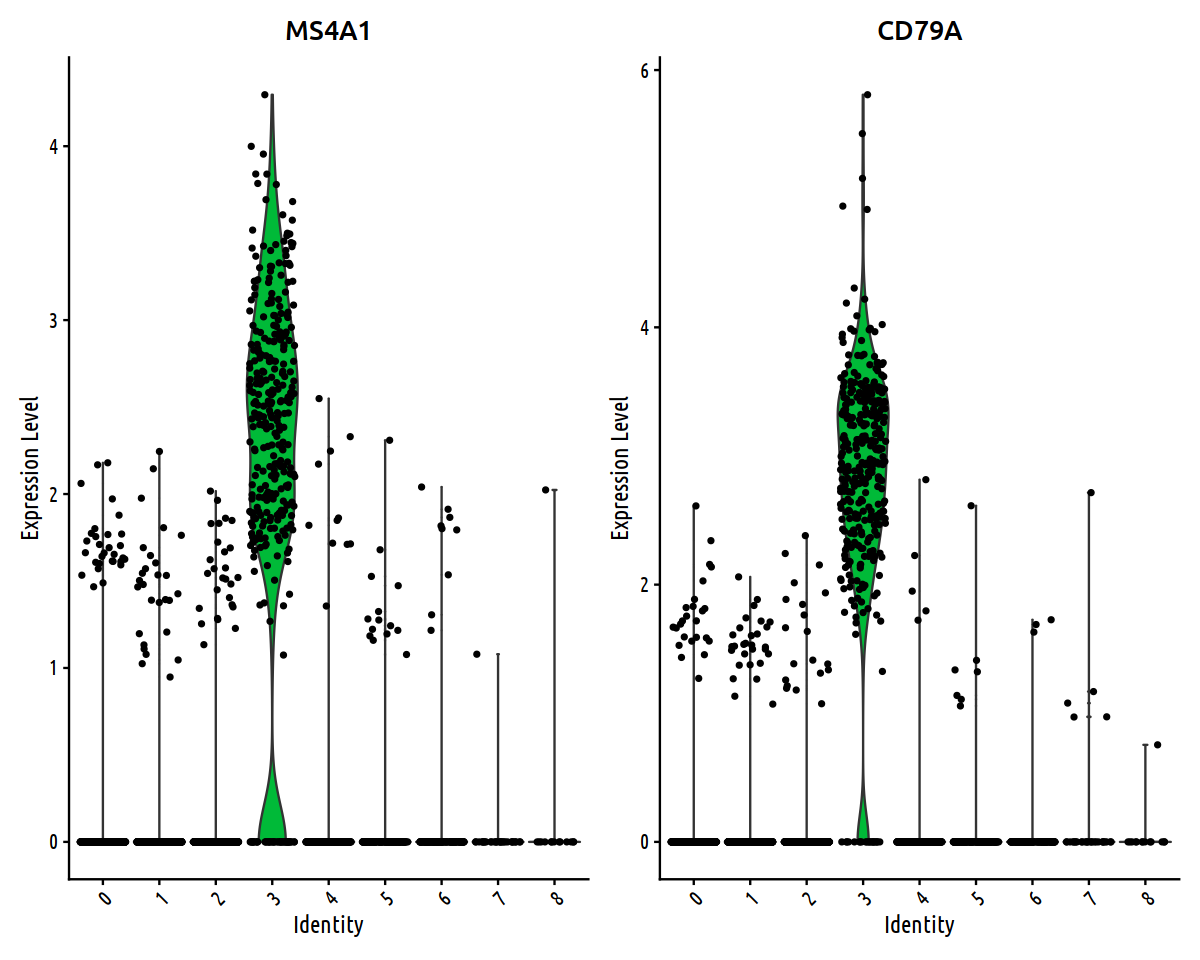

In [27]:
options(repr.plot.width=10, repr.plot.height=8)
VlnPlot(sc, features = c("MS4A1", "CD79A"))

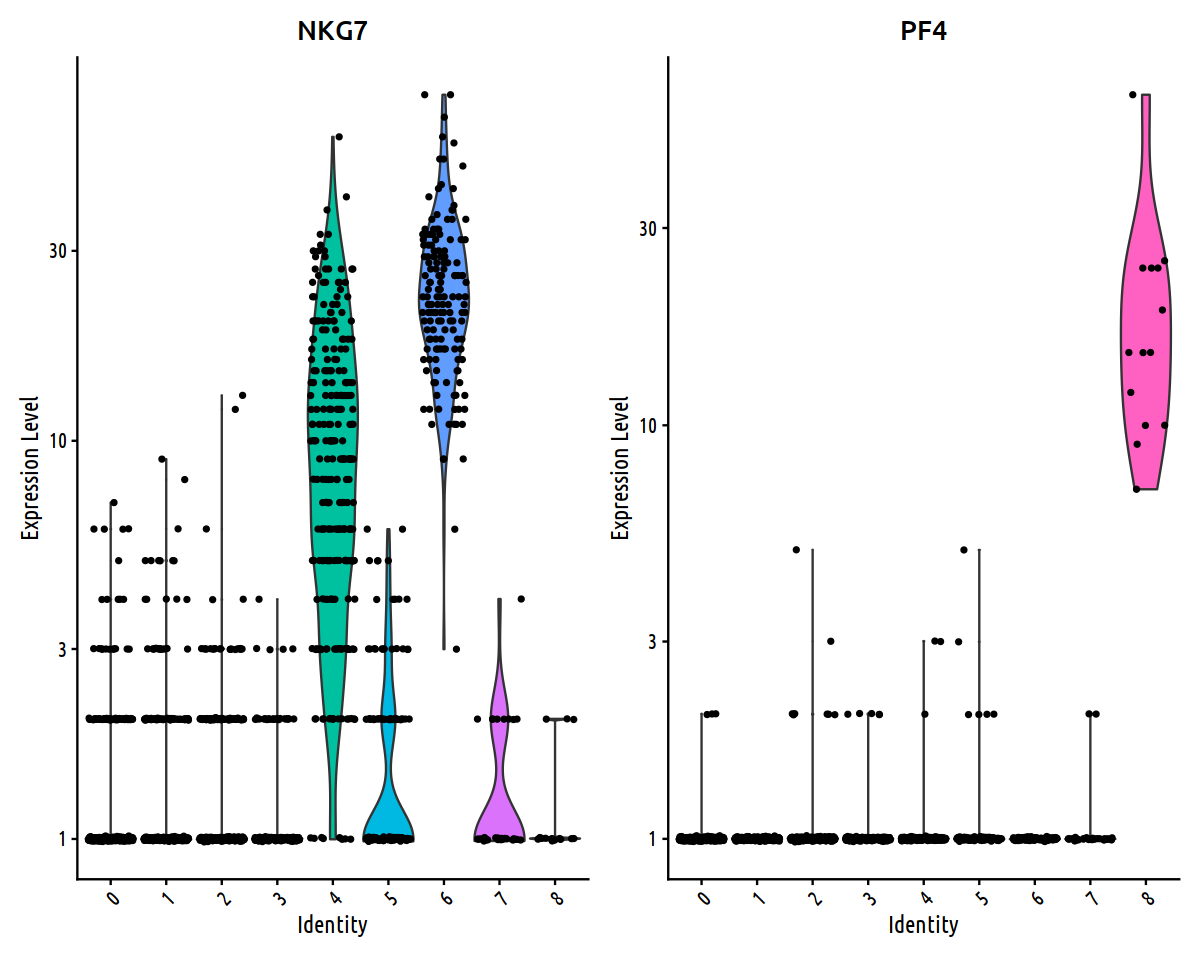

In [29]:
# you can plot raw counts as well
VlnPlot(sc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

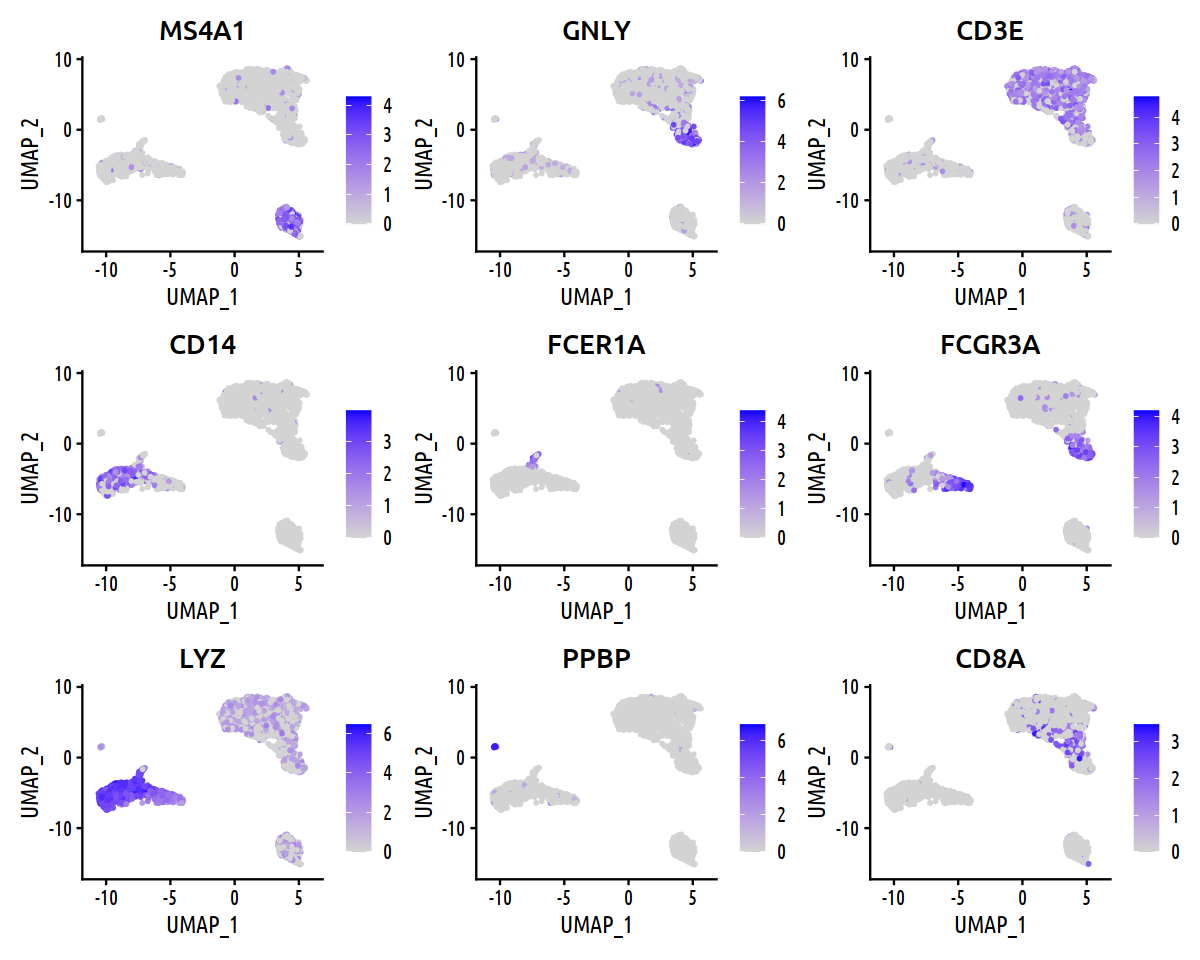

In [31]:
options(repr.plot.width=10, repr.plot.height=8)
FeaturePlot(sc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", 
    "CD8A"))

## Assigning cell type identity to clusters

Fortunately in the case of this dataset, we can use canonical markers to easily match the unbiased clustering to known cell types:

|Cluster ID|Markers |Cell Type|
|----------|--------|---------|
|0 |IL7R, CCR7 |Naive CD4+ T|
|1 |IL7R, S100A4 |Memory CD4+|
|2 |CD14, LYZ |CD14+ Mono|
|3 |MS4A1 |B|
|4 |CD8A |CD8+ T|
|5 |FCGR3A, MS4A7 |FCGR3A+ Mono|
|6 |GNLY, NKG7 |NK|
|7 |FCER1A, CST3 |DC|
|8 |PPBP |Platelet|

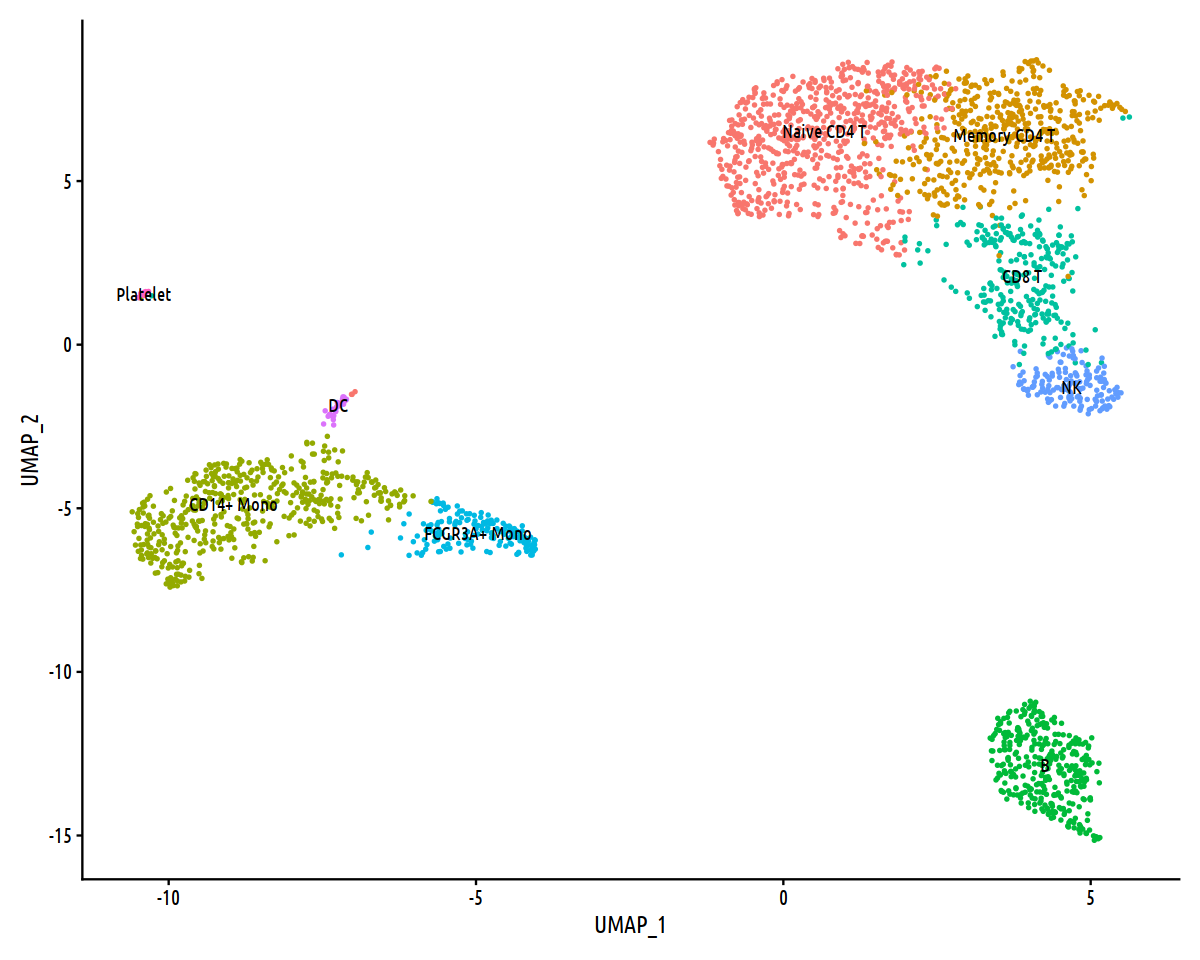

In [32]:
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono", 
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(sc)
sc <- RenameIdents(sc, new.cluster.ids)
DimPlot(sc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

<div align="right"><a href="#Table-of-content">Go to TOC</a></div>

## References

* [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html)

## Acknowledgement
The Imperial BRC Genomics Facility is supported by NIHR funding to the Imperial Biomedical Research Centre.